## Setup

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import random

import pydicom
from PIL import Image

import glob
from pathlib import Path

import torch
import torch.optim as optim
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from skimage.segmentation import mark_boundaries

from lime import lime_image

import gc

In [16]:
torch.set_num_threads(80)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
torch.cuda.get_device_name(1)

'TITAN RTX'

## Data preparation


In [19]:
pos_labels=["Pulmonary tumour","Pulmonary metastasis"]

In [20]:
verdict_df=pd.read_csv('/mnt/idms/PROJECTS/Lung/LungCT/Verdicts.csv')
statistics_df=pd.read_csv('/mnt/idms/PROJECTS/Lung/LungCT/Statistics.csv')
verdict_df.fillna(0,inplace=True)
statistics_df.fillna(0,inplace=True)

In [22]:
total_cases=len(verdict_df)
pos_cases=int(statistics_df.iloc[-1][pos_labels].sum())
neg_cases=total_cases-pos_cases
used_cases=64
prob_keep_pos=used_cases/(2*pos_cases)
prob_keep_neg=used_cases/(2*neg_cases)

In [23]:
cnt=0
cts=[]
labels=[]
for patient_path in glob.iglob(f'/mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/*'):
    diseases=verdict_df.loc[verdict_df['PatientID'] == patient_path].iloc[0]
    pos_diseases=np.array(diseases[pos_labels])
    pos_or_neg=np.any(pos_diseases==1.0)
    p_keep=prob_keep_pos if pos_or_neg else prob_keep_neg
    label=1.0 if pos_or_neg else 0.0
    cases = list(glob.glob(f'{patient_path}/*.npz'))
    if cases:
        case_path=random.choice(cases)
        #for case_path in glob.iglob(f'{patient_path}/*.npz'):
        cnt+=1
        if(pos_or_neg):
            print("Positive found")
        if np.random.choice([True, False],p=[p_keep,1-p_keep]):
            print(f"Case number {cnt} with name {case_path} is included")
            npz=np.load(case_path)
            ct=npz[npz.files[0]]
            cts.append(ct)
            labels.append(label)

Positive found
Positive found
Case number 54 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/54040/SE000010.npz is included
Positive found
Positive found
Case number 217 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/56162/SE000013.npz is included
Case number 228 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/55352/SE000012.npz is included
Case number 297 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/53916/SE000018.npz is included
Positive found
Positive found
Case number 410 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/53058/SE000012.npz is included
Positive found
Positive found
Case number 499 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/52035/SE000013.npz is included
Positive found
Positive found
Positive found
Positive found
Case number 548 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/54821/SE000010.npz is included
Positive found
Case number 576 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/52410/SE00000

Case number 3711 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/52752/SE000018.npz is included
Positive found
Case number 3714 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/51217/SE000011.npz is included
Positive found
Positive found
Case number 3721 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/50478/SE000010.npz is included
Positive found
Case number 3728 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/53889/SE000005.npz is included
Positive found
Positive found
Positive found
Case number 3810 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/54619/SE000029.npz is included
Positive found
Positive found
Positive found
Positive found
Positive found
Positive found
Positive found
Positive found
Positive found
Positive found
Positive found
Case number 3955 with name /mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped/50480/SE000009.npz is included
Positive found
Positive found
Positive found
Positive found
Positive found
Positive found
Positive found
P

In [24]:
labels=np.array(labels)

In [90]:
len(labels)

75

In [115]:
max_HU=max(np.max(ct) for ct in cts)
min_HU=min(np.max(ct) for ct in cts)
downsample_size=384
cropped_size=384
middle_slice_num=300
used_slices=30

In [ ]:
#slices=[Image.fromarray((s.pixel_array/max_HU)*255.0).convert("L").resize((downsample_size,downsample_size),resample=Image.LANCZOS) for s in slices]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(cts, labels, test_size=0.3, stratify=labels)

In [46]:
class CTLungSlice(Dataset):
    
    def __init__(self, X_data, y_data, transform=None):
        self.X_data = []
        self.y_data = []
        self.len=0
        for ct,lab in zip(X_data,y_data):
            slice_num=ct.shape[2]
            if slice_num>used_slices:
                mid=slice_num//2
                used_part=np.moveaxis(ct[:,:,(mid-middle_slice_num//2):(mid+middle_slice_num//2)],2,0)
                used_part=used_part[np.random.choice(used_part.shape[0],used_slices,replace=False)]
                self.X_data.append(used_part)
                self.y_data+=([lab]*used_slices)
                self.len+=used_slices
        self.X_data=np.concatenate(self.X_data).astype(np.uint8)
        self.y_data=np.array(self.y_data)
        self.transform = transform
            
        
    def __getitem__(self, index):
        x=self.X_data[index]
        y=self.y_data[index]
        if self.transform:
            x = self.transform(Image.fromarray(x*255/max_HU))
        return x, y
    
    def __len__ (self):
        return self.len

In [47]:
class CTLungWhole(Dataset):
    
    def __init__(self, X_data, y_data, transform=None):
        self.y_data = []
        self.X_data = []
        self.len=0
        for ct,lab in zip(X_data,y_data):
            slice_num=ct.shape[2]
            if slice_num>used_slices:
                mid=slice_num//2
                used_part=np.moveaxis(ct[:,:,(mid-middle_slice_num//2):(mid+middle_slice_num//2)],2,0)
                used_part=used_part[np.random.choice(used_part.shape[0],used_slices,replace=False)]
                self.X_data.append(used_part)
                self.y_data.append(lab)
                self.len+=1
        self.X_data=np.asarray(self.X_data).astype(np.uint8)
        self.y_data = np.array(y_data)
        self.transform = transform
        
    def __getitem__(self, index):
        y=self.y_data[index]
        x=[self.transform(Image.fromarray(item*255/max_HU)) for item in self.X_data[index]] if self.transform else self.X_data[index]
        return x, y
    
    def __len__ (self):
        return len(self.y_data)

In [48]:
batch_size=16

In [49]:
train_transform = transforms.Compose([
    transforms.RandomCrop(cropped_size),
    #transforms.ColorJitter(
    #    brightness=[0,2],
    #    contrast=[0,2]),
    transforms.ToTensor(),
    #transforms.Normalize(0,1)
])

test_transform = transforms.Compose([
    transforms.CenterCrop(cropped_size),
    transforms.ToTensor(),
    #transforms.Normalize(0,1)
])
    
train_dataset = CTLungSlice(X_train, torch.FloatTensor(y_train), transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
test_dataset = CTLungSlice(X_test,torch.FloatTensor(y_test), transform=test_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

whole_test_dataset = CTLungWhole(X_test,torch.FloatTensor(y_test), transform=test_transform)
whole_test_loader = DataLoader(dataset=whole_test_dataset, batch_size=1, shuffle=False)

In [37]:
sample_img,_=next(iter(train_loader))
sample_img.shape

/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370120218/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


torch.Size([16, 1, 384, 384])

## CNN, train, validating

In [50]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.elu = nn.ELU()
        size_before_fc=((cropped_size-4)//2-4)//2
        self.fc1 = nn.Linear(size_before_fc*size_before_fc*64, num_classes)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    def forward(self, x):
        x = self.elu(self.max_pool(self.conv1(x)))
        x = self.elu(self.max_pool(self.conv2_drop(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [51]:
def evaluate(pred, lab):
    binary_pred = pred>0
    binary_lab = lab>0.5
    common = binary_pred==binary_lab
    return torch.sum(common).item()

In [52]:
log_freq=1

In [63]:
def base_train_step(model,device,optimizer,criterion,train_loader):
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(-1, 1, cropped_size, cropped_size)
        labels = labels.view(-1, 1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % log_freq == 0:
            batch_performance=evaluate(outputs, labels)
            print(f"Batch {batch_idx+1} / {len(train_loader)} | Loss = {loss},  Correct = {batch_performance} / {len(labels)}, Ill = {(labels==1).sum().item()}")

In [67]:
def base_model_eval(model,criterion,device,test_loader):
    total = 0
    correct = 0
    zz = 0
    val_loss=0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(-1, 1, cropped_size, cropped_size)
            labels = labels.view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss+=loss
            total += labels.size(0)
            correct += evaluate(outputs, labels)
            if batch_idx % log_freq == 0:
                batch_performance=evaluate(outputs, labels)
                print(f"Batch {batch_idx+1} / {len(test_loader)} |  Correct = {batch_performance} / {len(labels)}, Ill = {(labels==1).sum().item()}")
    return correct,total,val_loss

In [68]:
torch.cuda.empty_cache()
del model_base
gc.collect()

118

In [69]:
epochs = 25
learning_rate = 0.001
act_max=0.0


model_base = CNN(num_classes=1).to(device)
criterion_base = nn.BCEWithLogitsLoss() 
optimizer_base = optim.SGD(model_base.parameters(), lr=learning_rate)
scheduler_base = optim.lr_scheduler.ReduceLROnPlateau(optimizer_base, patience=2, verbose=True)

params=[]

for epoch in range(epochs):
    base_train_step(model_base,device,optimizer_base,criterion_base, train_loader)
    correct, total, val_loss = base_model_eval(model_base,criterion_base,device,test_loader)
    scheduler_base.step(val_loss)
    #correct_tr, total_tr = base_model_eval(model_base,device,train_loader)
    print(epoch,"acc:",correct/total," raw: ",correct,total,)#"acc_tr:",correct_tr/total_tr," raw_tr: ",correct_tr,total_tr)
    if correct/total>act_max:
        print("IMPROVED")
        act_max = correct/total
    params.append(model_base.parameters())

Batch 1 / 98 | Loss = 0.6943548321723938,  Correct = 8 / 16, Ill = 8
Batch 2 / 98 | Loss = 0.6829075813293457,  Correct = 11 / 16, Ill = 10
Batch 3 / 98 | Loss = 0.7351962924003601,  Correct = 7 / 16, Ill = 7
Batch 4 / 98 | Loss = 0.6881343126296997,  Correct = 6 / 16, Ill = 5
Batch 5 / 98 | Loss = 0.8290377259254456,  Correct = 5 / 16, Ill = 11
Batch 6 / 98 | Loss = 0.6956759691238403,  Correct = 8 / 16, Ill = 8
Batch 7 / 98 | Loss = 0.6780279874801636,  Correct = 9 / 16, Ill = 9
Batch 8 / 98 | Loss = 0.7639975547790527,  Correct = 6 / 16, Ill = 6
Batch 9 / 98 | Loss = 0.6862308979034424,  Correct = 7 / 16, Ill = 7
Batch 10 / 98 | Loss = 0.6773489117622375,  Correct = 9 / 16, Ill = 8
Batch 11 / 98 | Loss = 0.6805654764175415,  Correct = 10 / 16, Ill = 9
Batch 12 / 98 | Loss = 0.7442242503166199,  Correct = 5 / 16, Ill = 7
Batch 13 / 98 | Loss = 0.6332380771636963,  Correct = 11 / 16, Ill = 7
Batch 14 / 98 | Loss = 0.672372579574585,  Correct = 8 / 16, Ill = 8
Batch 15 / 98 | Loss = 0.

Batch 40 / 690 |  Correct = 1 / 1, Ill = 1
Batch 41 / 690 |  Correct = 1 / 1, Ill = 1
Batch 42 / 690 |  Correct = 0 / 1, Ill = 1
Batch 43 / 690 |  Correct = 1 / 1, Ill = 1
Batch 44 / 690 |  Correct = 1 / 1, Ill = 1
Batch 45 / 690 |  Correct = 1 / 1, Ill = 1
Batch 46 / 690 |  Correct = 1 / 1, Ill = 1
Batch 47 / 690 |  Correct = 1 / 1, Ill = 1
Batch 48 / 690 |  Correct = 1 / 1, Ill = 1
Batch 49 / 690 |  Correct = 0 / 1, Ill = 1
Batch 50 / 690 |  Correct = 1 / 1, Ill = 1
Batch 51 / 690 |  Correct = 1 / 1, Ill = 1
Batch 52 / 690 |  Correct = 1 / 1, Ill = 1
Batch 53 / 690 |  Correct = 0 / 1, Ill = 1
Batch 54 / 690 |  Correct = 1 / 1, Ill = 1
Batch 55 / 690 |  Correct = 1 / 1, Ill = 1
Batch 56 / 690 |  Correct = 1 / 1, Ill = 1
Batch 57 / 690 |  Correct = 1 / 1, Ill = 1
Batch 58 / 690 |  Correct = 1 / 1, Ill = 1
Batch 59 / 690 |  Correct = 1 / 1, Ill = 1
Batch 60 / 690 |  Correct = 1 / 1, Ill = 1
Batch 61 / 690 |  Correct = 1 / 1, Ill = 1
Batch 62 / 690 |  Correct = 1 / 1, Ill = 1
Batch 63 / 

Batch 228 / 690 |  Correct = 1 / 1, Ill = 1
Batch 229 / 690 |  Correct = 1 / 1, Ill = 1
Batch 230 / 690 |  Correct = 1 / 1, Ill = 1
Batch 231 / 690 |  Correct = 1 / 1, Ill = 1
Batch 232 / 690 |  Correct = 1 / 1, Ill = 1
Batch 233 / 690 |  Correct = 1 / 1, Ill = 1
Batch 234 / 690 |  Correct = 1 / 1, Ill = 1
Batch 235 / 690 |  Correct = 1 / 1, Ill = 1
Batch 236 / 690 |  Correct = 1 / 1, Ill = 1
Batch 237 / 690 |  Correct = 1 / 1, Ill = 1
Batch 238 / 690 |  Correct = 1 / 1, Ill = 1
Batch 239 / 690 |  Correct = 1 / 1, Ill = 1
Batch 240 / 690 |  Correct = 1 / 1, Ill = 1
Batch 241 / 690 |  Correct = 0 / 1, Ill = 0
Batch 242 / 690 |  Correct = 1 / 1, Ill = 0
Batch 243 / 690 |  Correct = 1 / 1, Ill = 0
Batch 244 / 690 |  Correct = 0 / 1, Ill = 0
Batch 245 / 690 |  Correct = 0 / 1, Ill = 0
Batch 246 / 690 |  Correct = 0 / 1, Ill = 0
Batch 247 / 690 |  Correct = 0 / 1, Ill = 0
Batch 248 / 690 |  Correct = 0 / 1, Ill = 0
Batch 249 / 690 |  Correct = 0 / 1, Ill = 0
Batch 250 / 690 |  Correct = 0 /

Batch 418 / 690 |  Correct = 0 / 1, Ill = 0
Batch 419 / 690 |  Correct = 0 / 1, Ill = 0
Batch 420 / 690 |  Correct = 1 / 1, Ill = 0
Batch 421 / 690 |  Correct = 1 / 1, Ill = 1
Batch 422 / 690 |  Correct = 1 / 1, Ill = 1
Batch 423 / 690 |  Correct = 1 / 1, Ill = 1
Batch 424 / 690 |  Correct = 1 / 1, Ill = 1
Batch 425 / 690 |  Correct = 0 / 1, Ill = 1
Batch 426 / 690 |  Correct = 1 / 1, Ill = 1
Batch 427 / 690 |  Correct = 1 / 1, Ill = 1
Batch 428 / 690 |  Correct = 1 / 1, Ill = 1
Batch 429 / 690 |  Correct = 1 / 1, Ill = 1
Batch 430 / 690 |  Correct = 1 / 1, Ill = 1
Batch 431 / 690 |  Correct = 1 / 1, Ill = 1
Batch 432 / 690 |  Correct = 1 / 1, Ill = 1
Batch 433 / 690 |  Correct = 0 / 1, Ill = 1
Batch 434 / 690 |  Correct = 1 / 1, Ill = 1
Batch 435 / 690 |  Correct = 0 / 1, Ill = 1
Batch 436 / 690 |  Correct = 1 / 1, Ill = 1
Batch 437 / 690 |  Correct = 1 / 1, Ill = 1
Batch 438 / 690 |  Correct = 0 / 1, Ill = 1
Batch 439 / 690 |  Correct = 1 / 1, Ill = 1
Batch 440 / 690 |  Correct = 1 /

Batch 605 / 690 |  Correct = 0 / 1, Ill = 0
Batch 606 / 690 |  Correct = 0 / 1, Ill = 0
Batch 607 / 690 |  Correct = 0 / 1, Ill = 0
Batch 608 / 690 |  Correct = 0 / 1, Ill = 0
Batch 609 / 690 |  Correct = 0 / 1, Ill = 0
Batch 610 / 690 |  Correct = 0 / 1, Ill = 0
Batch 611 / 690 |  Correct = 0 / 1, Ill = 0
Batch 612 / 690 |  Correct = 0 / 1, Ill = 0
Batch 613 / 690 |  Correct = 0 / 1, Ill = 0
Batch 614 / 690 |  Correct = 0 / 1, Ill = 0
Batch 615 / 690 |  Correct = 0 / 1, Ill = 0
Batch 616 / 690 |  Correct = 0 / 1, Ill = 0
Batch 617 / 690 |  Correct = 1 / 1, Ill = 0
Batch 618 / 690 |  Correct = 0 / 1, Ill = 0
Batch 619 / 690 |  Correct = 0 / 1, Ill = 0
Batch 620 / 690 |  Correct = 0 / 1, Ill = 0
Batch 621 / 690 |  Correct = 1 / 1, Ill = 0
Batch 622 / 690 |  Correct = 0 / 1, Ill = 0
Batch 623 / 690 |  Correct = 0 / 1, Ill = 0
Batch 624 / 690 |  Correct = 0 / 1, Ill = 0
Batch 625 / 690 |  Correct = 1 / 1, Ill = 0
Batch 626 / 690 |  Correct = 0 / 1, Ill = 0
Batch 627 / 690 |  Correct = 0 /

Batch 63 / 98 | Loss = 0.7235245704650879,  Correct = 7 / 16, Ill = 9
Batch 64 / 98 | Loss = 0.6426486968994141,  Correct = 12 / 16, Ill = 8
Batch 65 / 98 | Loss = 0.7057055234909058,  Correct = 7 / 16, Ill = 8
Batch 66 / 98 | Loss = 0.7197870016098022,  Correct = 4 / 16, Ill = 8
Batch 67 / 98 | Loss = 0.7280049324035645,  Correct = 8 / 16, Ill = 10
Batch 68 / 98 | Loss = 0.6986087560653687,  Correct = 10 / 16, Ill = 9
Batch 69 / 98 | Loss = 0.6896345615386963,  Correct = 8 / 16, Ill = 10
Batch 70 / 98 | Loss = 0.7342885732650757,  Correct = 7 / 16, Ill = 7
Batch 71 / 98 | Loss = 0.7018717527389526,  Correct = 9 / 16, Ill = 10
Batch 72 / 98 | Loss = 0.6973674893379211,  Correct = 8 / 16, Ill = 5
Batch 73 / 98 | Loss = 0.6745893955230713,  Correct = 10 / 16, Ill = 7
Batch 74 / 98 | Loss = 0.6617532968521118,  Correct = 8 / 16, Ill = 4
Batch 75 / 98 | Loss = 0.6168912649154663,  Correct = 11 / 16, Ill = 5
Batch 76 / 98 | Loss = 0.6929365992546082,  Correct = 9 / 16, Ill = 7
Batch 77 / 98

Batch 133 / 690 |  Correct = 0 / 1, Ill = 1
Batch 134 / 690 |  Correct = 1 / 1, Ill = 1
Batch 135 / 690 |  Correct = 0 / 1, Ill = 1
Batch 136 / 690 |  Correct = 1 / 1, Ill = 1
Batch 137 / 690 |  Correct = 1 / 1, Ill = 1
Batch 138 / 690 |  Correct = 0 / 1, Ill = 1
Batch 139 / 690 |  Correct = 1 / 1, Ill = 1
Batch 140 / 690 |  Correct = 0 / 1, Ill = 1
Batch 141 / 690 |  Correct = 0 / 1, Ill = 1
Batch 142 / 690 |  Correct = 0 / 1, Ill = 1
Batch 143 / 690 |  Correct = 0 / 1, Ill = 1
Batch 144 / 690 |  Correct = 0 / 1, Ill = 1
Batch 145 / 690 |  Correct = 1 / 1, Ill = 1
Batch 146 / 690 |  Correct = 0 / 1, Ill = 1
Batch 147 / 690 |  Correct = 0 / 1, Ill = 1
Batch 148 / 690 |  Correct = 1 / 1, Ill = 1
Batch 149 / 690 |  Correct = 0 / 1, Ill = 1
Batch 150 / 690 |  Correct = 1 / 1, Ill = 1
Batch 151 / 690 |  Correct = 0 / 1, Ill = 1
Batch 152 / 690 |  Correct = 1 / 1, Ill = 1
Batch 153 / 690 |  Correct = 0 / 1, Ill = 1
Batch 154 / 690 |  Correct = 0 / 1, Ill = 1
Batch 155 / 690 |  Correct = 0 /

Batch 320 / 690 |  Correct = 0 / 1, Ill = 1
Batch 321 / 690 |  Correct = 0 / 1, Ill = 1
Batch 322 / 690 |  Correct = 1 / 1, Ill = 1
Batch 323 / 690 |  Correct = 0 / 1, Ill = 1
Batch 324 / 690 |  Correct = 0 / 1, Ill = 1
Batch 325 / 690 |  Correct = 1 / 1, Ill = 1
Batch 326 / 690 |  Correct = 0 / 1, Ill = 1
Batch 327 / 690 |  Correct = 1 / 1, Ill = 1
Batch 328 / 690 |  Correct = 1 / 1, Ill = 1
Batch 329 / 690 |  Correct = 1 / 1, Ill = 1
Batch 330 / 690 |  Correct = 1 / 1, Ill = 1
Batch 331 / 690 |  Correct = 0 / 1, Ill = 1
Batch 332 / 690 |  Correct = 1 / 1, Ill = 1
Batch 333 / 690 |  Correct = 0 / 1, Ill = 1
Batch 334 / 690 |  Correct = 0 / 1, Ill = 1
Batch 335 / 690 |  Correct = 1 / 1, Ill = 1
Batch 336 / 690 |  Correct = 0 / 1, Ill = 1
Batch 337 / 690 |  Correct = 1 / 1, Ill = 1
Batch 338 / 690 |  Correct = 1 / 1, Ill = 1
Batch 339 / 690 |  Correct = 0 / 1, Ill = 1
Batch 340 / 690 |  Correct = 0 / 1, Ill = 1
Batch 341 / 690 |  Correct = 0 / 1, Ill = 1
Batch 342 / 690 |  Correct = 1 /

Batch 512 / 690 |  Correct = 0 / 1, Ill = 0
Batch 513 / 690 |  Correct = 1 / 1, Ill = 0
Batch 514 / 690 |  Correct = 1 / 1, Ill = 0
Batch 515 / 690 |  Correct = 1 / 1, Ill = 0
Batch 516 / 690 |  Correct = 0 / 1, Ill = 0
Batch 517 / 690 |  Correct = 0 / 1, Ill = 0
Batch 518 / 690 |  Correct = 1 / 1, Ill = 0
Batch 519 / 690 |  Correct = 1 / 1, Ill = 0
Batch 520 / 690 |  Correct = 0 / 1, Ill = 0
Batch 521 / 690 |  Correct = 1 / 1, Ill = 0
Batch 522 / 690 |  Correct = 1 / 1, Ill = 0
Batch 523 / 690 |  Correct = 0 / 1, Ill = 0
Batch 524 / 690 |  Correct = 0 / 1, Ill = 0
Batch 525 / 690 |  Correct = 0 / 1, Ill = 0
Batch 526 / 690 |  Correct = 1 / 1, Ill = 0
Batch 527 / 690 |  Correct = 0 / 1, Ill = 0
Batch 528 / 690 |  Correct = 0 / 1, Ill = 0
Batch 529 / 690 |  Correct = 0 / 1, Ill = 0
Batch 530 / 690 |  Correct = 1 / 1, Ill = 0
Batch 531 / 690 |  Correct = 1 / 1, Ill = 0
Batch 532 / 690 |  Correct = 1 / 1, Ill = 0
Batch 533 / 690 |  Correct = 0 / 1, Ill = 0
Batch 534 / 690 |  Correct = 1 /

Batch 5 / 98 | Loss = 0.736797571182251,  Correct = 7 / 16, Ill = 7
Batch 6 / 98 | Loss = 0.7131426334381104,  Correct = 5 / 16, Ill = 7
Batch 7 / 98 | Loss = 0.7282527685165405,  Correct = 5 / 16, Ill = 5
Batch 8 / 98 | Loss = 0.7043079733848572,  Correct = 7 / 16, Ill = 9
Batch 9 / 98 | Loss = 0.6854523420333862,  Correct = 9 / 16, Ill = 10
Batch 10 / 98 | Loss = 0.7136688232421875,  Correct = 7 / 16, Ill = 8
Batch 11 / 98 | Loss = 0.6931068897247314,  Correct = 9 / 16, Ill = 10
Batch 12 / 98 | Loss = 0.6708128452301025,  Correct = 8 / 16, Ill = 10
Batch 13 / 98 | Loss = 0.7659034132957458,  Correct = 6 / 16, Ill = 6
Batch 14 / 98 | Loss = 0.6822474002838135,  Correct = 10 / 16, Ill = 9
Batch 15 / 98 | Loss = 0.661296010017395,  Correct = 11 / 16, Ill = 11
Batch 16 / 98 | Loss = 0.6879388093948364,  Correct = 9 / 16, Ill = 9
Batch 17 / 98 | Loss = 0.7030692100524902,  Correct = 8 / 16, Ill = 7
Batch 18 / 98 | Loss = 0.7219000458717346,  Correct = 6 / 16, Ill = 8
Batch 19 / 98 | Loss 

Batch 46 / 690 |  Correct = 0 / 1, Ill = 1
Batch 47 / 690 |  Correct = 0 / 1, Ill = 1
Batch 48 / 690 |  Correct = 1 / 1, Ill = 1
Batch 49 / 690 |  Correct = 1 / 1, Ill = 1
Batch 50 / 690 |  Correct = 0 / 1, Ill = 1
Batch 51 / 690 |  Correct = 0 / 1, Ill = 1
Batch 52 / 690 |  Correct = 1 / 1, Ill = 1
Batch 53 / 690 |  Correct = 0 / 1, Ill = 1
Batch 54 / 690 |  Correct = 0 / 1, Ill = 1
Batch 55 / 690 |  Correct = 0 / 1, Ill = 1
Batch 56 / 690 |  Correct = 1 / 1, Ill = 1
Batch 57 / 690 |  Correct = 1 / 1, Ill = 1
Batch 58 / 690 |  Correct = 1 / 1, Ill = 1
Batch 59 / 690 |  Correct = 1 / 1, Ill = 1
Batch 60 / 690 |  Correct = 1 / 1, Ill = 1
Batch 61 / 690 |  Correct = 1 / 1, Ill = 1
Batch 62 / 690 |  Correct = 1 / 1, Ill = 1
Batch 63 / 690 |  Correct = 0 / 1, Ill = 1
Batch 64 / 690 |  Correct = 1 / 1, Ill = 1
Batch 65 / 690 |  Correct = 0 / 1, Ill = 1
Batch 66 / 690 |  Correct = 1 / 1, Ill = 1
Batch 67 / 690 |  Correct = 0 / 1, Ill = 1
Batch 68 / 690 |  Correct = 0 / 1, Ill = 1
Batch 69 / 

Batch 236 / 690 |  Correct = 1 / 1, Ill = 1
Batch 237 / 690 |  Correct = 1 / 1, Ill = 1
Batch 238 / 690 |  Correct = 1 / 1, Ill = 1
Batch 239 / 690 |  Correct = 1 / 1, Ill = 1
Batch 240 / 690 |  Correct = 1 / 1, Ill = 1
Batch 241 / 690 |  Correct = 0 / 1, Ill = 0
Batch 242 / 690 |  Correct = 0 / 1, Ill = 0
Batch 243 / 690 |  Correct = 0 / 1, Ill = 0
Batch 244 / 690 |  Correct = 1 / 1, Ill = 0
Batch 245 / 690 |  Correct = 0 / 1, Ill = 0
Batch 246 / 690 |  Correct = 1 / 1, Ill = 0
Batch 247 / 690 |  Correct = 0 / 1, Ill = 0
Batch 248 / 690 |  Correct = 0 / 1, Ill = 0
Batch 249 / 690 |  Correct = 0 / 1, Ill = 0
Batch 250 / 690 |  Correct = 0 / 1, Ill = 0
Batch 251 / 690 |  Correct = 0 / 1, Ill = 0
Batch 252 / 690 |  Correct = 0 / 1, Ill = 0
Batch 253 / 690 |  Correct = 0 / 1, Ill = 0
Batch 254 / 690 |  Correct = 0 / 1, Ill = 0
Batch 255 / 690 |  Correct = 0 / 1, Ill = 0
Batch 256 / 690 |  Correct = 0 / 1, Ill = 0
Batch 257 / 690 |  Correct = 0 / 1, Ill = 0
Batch 258 / 690 |  Correct = 0 /

Batch 430 / 690 |  Correct = 0 / 1, Ill = 1
Batch 431 / 690 |  Correct = 1 / 1, Ill = 1
Batch 432 / 690 |  Correct = 0 / 1, Ill = 1
Batch 433 / 690 |  Correct = 1 / 1, Ill = 1
Batch 434 / 690 |  Correct = 0 / 1, Ill = 1
Batch 435 / 690 |  Correct = 0 / 1, Ill = 1
Batch 436 / 690 |  Correct = 1 / 1, Ill = 1
Batch 437 / 690 |  Correct = 1 / 1, Ill = 1
Batch 438 / 690 |  Correct = 1 / 1, Ill = 1
Batch 439 / 690 |  Correct = 0 / 1, Ill = 1
Batch 440 / 690 |  Correct = 1 / 1, Ill = 1
Batch 441 / 690 |  Correct = 1 / 1, Ill = 1
Batch 442 / 690 |  Correct = 1 / 1, Ill = 1
Batch 443 / 690 |  Correct = 0 / 1, Ill = 1
Batch 444 / 690 |  Correct = 0 / 1, Ill = 1
Batch 445 / 690 |  Correct = 0 / 1, Ill = 1
Batch 446 / 690 |  Correct = 1 / 1, Ill = 1
Batch 447 / 690 |  Correct = 1 / 1, Ill = 1
Batch 448 / 690 |  Correct = 0 / 1, Ill = 1
Batch 449 / 690 |  Correct = 1 / 1, Ill = 1
Batch 450 / 690 |  Correct = 0 / 1, Ill = 1
Batch 451 / 690 |  Correct = 0 / 1, Ill = 1
Batch 452 / 690 |  Correct = 0 /

Batch 623 / 690 |  Correct = 0 / 1, Ill = 0
Batch 624 / 690 |  Correct = 1 / 1, Ill = 0
Batch 625 / 690 |  Correct = 1 / 1, Ill = 0
Batch 626 / 690 |  Correct = 0 / 1, Ill = 0
Batch 627 / 690 |  Correct = 0 / 1, Ill = 0
Batch 628 / 690 |  Correct = 1 / 1, Ill = 0
Batch 629 / 690 |  Correct = 0 / 1, Ill = 0
Batch 630 / 690 |  Correct = 1 / 1, Ill = 0
Batch 631 / 690 |  Correct = 0 / 1, Ill = 0
Batch 632 / 690 |  Correct = 1 / 1, Ill = 0
Batch 633 / 690 |  Correct = 0 / 1, Ill = 0
Batch 634 / 690 |  Correct = 0 / 1, Ill = 0
Batch 635 / 690 |  Correct = 0 / 1, Ill = 0
Batch 636 / 690 |  Correct = 0 / 1, Ill = 0
Batch 637 / 690 |  Correct = 0 / 1, Ill = 0
Batch 638 / 690 |  Correct = 0 / 1, Ill = 0
Batch 639 / 690 |  Correct = 0 / 1, Ill = 0
Batch 640 / 690 |  Correct = 1 / 1, Ill = 0
Batch 641 / 690 |  Correct = 0 / 1, Ill = 0
Batch 642 / 690 |  Correct = 1 / 1, Ill = 0
Batch 643 / 690 |  Correct = 0 / 1, Ill = 0
Batch 644 / 690 |  Correct = 0 / 1, Ill = 0
Batch 645 / 690 |  Correct = 0 /

Batch 75 / 98 | Loss = 0.6929490566253662,  Correct = 8 / 16, Ill = 8
Batch 76 / 98 | Loss = 0.669554591178894,  Correct = 10 / 16, Ill = 9
Batch 77 / 98 | Loss = 0.6642234921455383,  Correct = 9 / 16, Ill = 10
Batch 78 / 98 | Loss = 0.7073725461959839,  Correct = 7 / 16, Ill = 7
Batch 79 / 98 | Loss = 0.6885015964508057,  Correct = 8 / 16, Ill = 8
Batch 80 / 98 | Loss = 0.7414411902427673,  Correct = 4 / 16, Ill = 6
Batch 81 / 98 | Loss = 0.6804672479629517,  Correct = 9 / 16, Ill = 11
Batch 82 / 98 | Loss = 0.6747131943702698,  Correct = 9 / 16, Ill = 11
Batch 83 / 98 | Loss = 0.6262555718421936,  Correct = 14 / 16, Ill = 11
Batch 84 / 98 | Loss = 0.6910874247550964,  Correct = 7 / 16, Ill = 7
Batch 85 / 98 | Loss = 0.6935682892799377,  Correct = 6 / 16, Ill = 7
Batch 86 / 98 | Loss = 0.7545458078384399,  Correct = 5 / 16, Ill = 4
Batch 87 / 98 | Loss = 0.6679898500442505,  Correct = 10 / 16, Ill = 9
Batch 88 / 98 | Loss = 0.6562163829803467,  Correct = 12 / 16, Ill = 9
Batch 89 / 98

Batch 153 / 690 |  Correct = 1 / 1, Ill = 1
Batch 154 / 690 |  Correct = 1 / 1, Ill = 1
Batch 155 / 690 |  Correct = 1 / 1, Ill = 1
Batch 156 / 690 |  Correct = 1 / 1, Ill = 1
Batch 157 / 690 |  Correct = 1 / 1, Ill = 1
Batch 158 / 690 |  Correct = 0 / 1, Ill = 1
Batch 159 / 690 |  Correct = 0 / 1, Ill = 1
Batch 160 / 690 |  Correct = 1 / 1, Ill = 1
Batch 161 / 690 |  Correct = 0 / 1, Ill = 1
Batch 162 / 690 |  Correct = 1 / 1, Ill = 1
Batch 163 / 690 |  Correct = 0 / 1, Ill = 1
Batch 164 / 690 |  Correct = 1 / 1, Ill = 1
Batch 165 / 690 |  Correct = 1 / 1, Ill = 1
Batch 166 / 690 |  Correct = 0 / 1, Ill = 1
Batch 167 / 690 |  Correct = 0 / 1, Ill = 1
Batch 168 / 690 |  Correct = 0 / 1, Ill = 1
Batch 169 / 690 |  Correct = 1 / 1, Ill = 1
Batch 170 / 690 |  Correct = 1 / 1, Ill = 1
Batch 171 / 690 |  Correct = 1 / 1, Ill = 1
Batch 172 / 690 |  Correct = 0 / 1, Ill = 1
Batch 173 / 690 |  Correct = 0 / 1, Ill = 1
Batch 174 / 690 |  Correct = 1 / 1, Ill = 1
Batch 175 / 690 |  Correct = 1 /

Batch 348 / 690 |  Correct = 1 / 1, Ill = 1
Batch 349 / 690 |  Correct = 0 / 1, Ill = 1
Batch 350 / 690 |  Correct = 0 / 1, Ill = 1
Batch 351 / 690 |  Correct = 1 / 1, Ill = 1
Batch 352 / 690 |  Correct = 1 / 1, Ill = 1
Batch 353 / 690 |  Correct = 1 / 1, Ill = 1
Batch 354 / 690 |  Correct = 1 / 1, Ill = 1
Batch 355 / 690 |  Correct = 0 / 1, Ill = 1
Batch 356 / 690 |  Correct = 1 / 1, Ill = 1
Batch 357 / 690 |  Correct = 1 / 1, Ill = 1
Batch 358 / 690 |  Correct = 1 / 1, Ill = 1
Batch 359 / 690 |  Correct = 0 / 1, Ill = 1
Batch 360 / 690 |  Correct = 0 / 1, Ill = 1
Batch 361 / 690 |  Correct = 0 / 1, Ill = 0
Batch 362 / 690 |  Correct = 1 / 1, Ill = 0
Batch 363 / 690 |  Correct = 1 / 1, Ill = 0
Batch 364 / 690 |  Correct = 1 / 1, Ill = 0
Batch 365 / 690 |  Correct = 0 / 1, Ill = 0
Batch 366 / 690 |  Correct = 0 / 1, Ill = 0
Batch 367 / 690 |  Correct = 0 / 1, Ill = 0
Batch 368 / 690 |  Correct = 1 / 1, Ill = 0
Batch 369 / 690 |  Correct = 1 / 1, Ill = 0
Batch 370 / 690 |  Correct = 0 /

Batch 536 / 690 |  Correct = 0 / 1, Ill = 0
Batch 537 / 690 |  Correct = 1 / 1, Ill = 0
Batch 538 / 690 |  Correct = 1 / 1, Ill = 0
Batch 539 / 690 |  Correct = 0 / 1, Ill = 0
Batch 540 / 690 |  Correct = 0 / 1, Ill = 0
Batch 541 / 690 |  Correct = 1 / 1, Ill = 0
Batch 542 / 690 |  Correct = 1 / 1, Ill = 0
Batch 543 / 690 |  Correct = 0 / 1, Ill = 0
Batch 544 / 690 |  Correct = 0 / 1, Ill = 0
Batch 545 / 690 |  Correct = 1 / 1, Ill = 0
Batch 546 / 690 |  Correct = 1 / 1, Ill = 0
Batch 547 / 690 |  Correct = 1 / 1, Ill = 0
Batch 548 / 690 |  Correct = 1 / 1, Ill = 0
Batch 549 / 690 |  Correct = 0 / 1, Ill = 0
Batch 550 / 690 |  Correct = 0 / 1, Ill = 0
Batch 551 / 690 |  Correct = 1 / 1, Ill = 0
Batch 552 / 690 |  Correct = 1 / 1, Ill = 0
Batch 553 / 690 |  Correct = 1 / 1, Ill = 0
Batch 554 / 690 |  Correct = 1 / 1, Ill = 0
Batch 555 / 690 |  Correct = 0 / 1, Ill = 0
Batch 556 / 690 |  Correct = 1 / 1, Ill = 0
Batch 557 / 690 |  Correct = 0 / 1, Ill = 0
Batch 558 / 690 |  Correct = 0 /

Batch 21 / 98 | Loss = 0.6984343528747559,  Correct = 8 / 16, Ill = 7
Batch 22 / 98 | Loss = 0.7204158306121826,  Correct = 7 / 16, Ill = 5
Batch 23 / 98 | Loss = 0.6948907375335693,  Correct = 10 / 16, Ill = 6
Batch 24 / 98 | Loss = 0.6990782022476196,  Correct = 6 / 16, Ill = 8
Batch 25 / 98 | Loss = 0.6696010828018188,  Correct = 10 / 16, Ill = 6
Batch 26 / 98 | Loss = 0.6839149594306946,  Correct = 7 / 16, Ill = 8
Batch 27 / 98 | Loss = 0.6501067876815796,  Correct = 13 / 16, Ill = 6
Batch 28 / 98 | Loss = 0.6691316366195679,  Correct = 11 / 16, Ill = 6
Batch 29 / 98 | Loss = 0.7221531867980957,  Correct = 5 / 16, Ill = 11
Batch 30 / 98 | Loss = 0.6841419339179993,  Correct = 8 / 16, Ill = 10
Batch 31 / 98 | Loss = 0.6829783916473389,  Correct = 9 / 16, Ill = 9
Batch 32 / 98 | Loss = 0.6602594256401062,  Correct = 12 / 16, Ill = 13
Batch 33 / 98 | Loss = 0.6933081746101379,  Correct = 7 / 16, Ill = 7
Batch 34 / 98 | Loss = 0.7081021070480347,  Correct = 7 / 16, Ill = 5
Batch 35 / 9

Batch 66 / 690 |  Correct = 1 / 1, Ill = 1
Batch 67 / 690 |  Correct = 1 / 1, Ill = 1
Batch 68 / 690 |  Correct = 1 / 1, Ill = 1
Batch 69 / 690 |  Correct = 1 / 1, Ill = 1
Batch 70 / 690 |  Correct = 1 / 1, Ill = 1
Batch 71 / 690 |  Correct = 1 / 1, Ill = 1
Batch 72 / 690 |  Correct = 1 / 1, Ill = 1
Batch 73 / 690 |  Correct = 1 / 1, Ill = 1
Batch 74 / 690 |  Correct = 1 / 1, Ill = 1
Batch 75 / 690 |  Correct = 1 / 1, Ill = 1
Batch 76 / 690 |  Correct = 1 / 1, Ill = 1
Batch 77 / 690 |  Correct = 1 / 1, Ill = 1
Batch 78 / 690 |  Correct = 1 / 1, Ill = 1
Batch 79 / 690 |  Correct = 1 / 1, Ill = 1
Batch 80 / 690 |  Correct = 1 / 1, Ill = 1
Batch 81 / 690 |  Correct = 1 / 1, Ill = 1
Batch 82 / 690 |  Correct = 0 / 1, Ill = 1
Batch 83 / 690 |  Correct = 1 / 1, Ill = 1
Batch 84 / 690 |  Correct = 1 / 1, Ill = 1
Batch 85 / 690 |  Correct = 1 / 1, Ill = 1
Batch 86 / 690 |  Correct = 1 / 1, Ill = 1
Batch 87 / 690 |  Correct = 1 / 1, Ill = 1
Batch 88 / 690 |  Correct = 0 / 1, Ill = 1
Batch 89 / 

Batch 264 / 690 |  Correct = 0 / 1, Ill = 0
Batch 265 / 690 |  Correct = 0 / 1, Ill = 0
Batch 266 / 690 |  Correct = 0 / 1, Ill = 0
Batch 267 / 690 |  Correct = 0 / 1, Ill = 0
Batch 268 / 690 |  Correct = 0 / 1, Ill = 0
Batch 269 / 690 |  Correct = 0 / 1, Ill = 0
Batch 270 / 690 |  Correct = 0 / 1, Ill = 0
Batch 271 / 690 |  Correct = 1 / 1, Ill = 1
Batch 272 / 690 |  Correct = 1 / 1, Ill = 1
Batch 273 / 690 |  Correct = 1 / 1, Ill = 1
Batch 274 / 690 |  Correct = 1 / 1, Ill = 1
Batch 275 / 690 |  Correct = 1 / 1, Ill = 1
Batch 276 / 690 |  Correct = 1 / 1, Ill = 1
Batch 277 / 690 |  Correct = 1 / 1, Ill = 1
Batch 278 / 690 |  Correct = 1 / 1, Ill = 1
Batch 279 / 690 |  Correct = 1 / 1, Ill = 1
Batch 280 / 690 |  Correct = 1 / 1, Ill = 1
Batch 281 / 690 |  Correct = 1 / 1, Ill = 1
Batch 282 / 690 |  Correct = 1 / 1, Ill = 1
Batch 283 / 690 |  Correct = 1 / 1, Ill = 1
Batch 284 / 690 |  Correct = 1 / 1, Ill = 1
Batch 285 / 690 |  Correct = 1 / 1, Ill = 1
Batch 286 / 690 |  Correct = 1 /

Batch 460 / 690 |  Correct = 1 / 1, Ill = 1
Batch 461 / 690 |  Correct = 1 / 1, Ill = 1
Batch 462 / 690 |  Correct = 1 / 1, Ill = 1
Batch 463 / 690 |  Correct = 1 / 1, Ill = 1
Batch 464 / 690 |  Correct = 1 / 1, Ill = 1
Batch 465 / 690 |  Correct = 1 / 1, Ill = 1
Batch 466 / 690 |  Correct = 1 / 1, Ill = 1
Batch 467 / 690 |  Correct = 1 / 1, Ill = 1
Batch 468 / 690 |  Correct = 1 / 1, Ill = 1
Batch 469 / 690 |  Correct = 1 / 1, Ill = 1
Batch 470 / 690 |  Correct = 1 / 1, Ill = 1
Batch 471 / 690 |  Correct = 1 / 1, Ill = 1
Batch 472 / 690 |  Correct = 1 / 1, Ill = 1
Batch 473 / 690 |  Correct = 1 / 1, Ill = 1
Batch 474 / 690 |  Correct = 1 / 1, Ill = 1
Batch 475 / 690 |  Correct = 1 / 1, Ill = 1
Batch 476 / 690 |  Correct = 1 / 1, Ill = 1
Batch 477 / 690 |  Correct = 1 / 1, Ill = 1
Batch 478 / 690 |  Correct = 1 / 1, Ill = 1
Batch 479 / 690 |  Correct = 1 / 1, Ill = 1
Batch 480 / 690 |  Correct = 1 / 1, Ill = 1
Batch 481 / 690 |  Correct = 1 / 1, Ill = 1
Batch 482 / 690 |  Correct = 1 /

Batch 653 / 690 |  Correct = 1 / 1, Ill = 0
Batch 654 / 690 |  Correct = 0 / 1, Ill = 0
Batch 655 / 690 |  Correct = 0 / 1, Ill = 0
Batch 656 / 690 |  Correct = 0 / 1, Ill = 0
Batch 657 / 690 |  Correct = 0 / 1, Ill = 0
Batch 658 / 690 |  Correct = 0 / 1, Ill = 0
Batch 659 / 690 |  Correct = 0 / 1, Ill = 0
Batch 660 / 690 |  Correct = 0 / 1, Ill = 0
Batch 661 / 690 |  Correct = 0 / 1, Ill = 0
Batch 662 / 690 |  Correct = 0 / 1, Ill = 0
Batch 663 / 690 |  Correct = 0 / 1, Ill = 0
Batch 664 / 690 |  Correct = 0 / 1, Ill = 0
Batch 665 / 690 |  Correct = 0 / 1, Ill = 0
Batch 666 / 690 |  Correct = 0 / 1, Ill = 0
Batch 667 / 690 |  Correct = 0 / 1, Ill = 0
Batch 668 / 690 |  Correct = 0 / 1, Ill = 0
Batch 669 / 690 |  Correct = 1 / 1, Ill = 0
Batch 670 / 690 |  Correct = 0 / 1, Ill = 0
Batch 671 / 690 |  Correct = 0 / 1, Ill = 0
Batch 672 / 690 |  Correct = 0 / 1, Ill = 0
Batch 673 / 690 |  Correct = 0 / 1, Ill = 0
Batch 674 / 690 |  Correct = 0 / 1, Ill = 0
Batch 675 / 690 |  Correct = 0 /

Batch 93 / 98 | Loss = 0.7175317406654358,  Correct = 7 / 16, Ill = 7
Batch 94 / 98 | Loss = 0.6548731327056885,  Correct = 12 / 16, Ill = 10
Batch 95 / 98 | Loss = 0.6771420836448669,  Correct = 11 / 16, Ill = 10
Batch 96 / 98 | Loss = 0.6508537530899048,  Correct = 13 / 16, Ill = 10
Batch 97 / 98 | Loss = 0.6952444314956665,  Correct = 9 / 16, Ill = 9
Batch 98 / 98 | Loss = 0.7561130523681641,  Correct = 3 / 8, Ill = 3
Batch 1 / 690 |  Correct = 1 / 1, Ill = 1
Batch 2 / 690 |  Correct = 1 / 1, Ill = 1
Batch 3 / 690 |  Correct = 1 / 1, Ill = 1
Batch 4 / 690 |  Correct = 1 / 1, Ill = 1
Batch 5 / 690 |  Correct = 1 / 1, Ill = 1
Batch 6 / 690 |  Correct = 1 / 1, Ill = 1
Batch 7 / 690 |  Correct = 1 / 1, Ill = 1
Batch 8 / 690 |  Correct = 1 / 1, Ill = 1
Batch 9 / 690 |  Correct = 1 / 1, Ill = 1
Batch 10 / 690 |  Correct = 1 / 1, Ill = 1
Batch 11 / 690 |  Correct = 1 / 1, Ill = 1
Batch 12 / 690 |  Correct = 1 / 1, Ill = 1
Batch 13 / 690 |  Correct = 1 / 1, Ill = 1
Batch 14 / 690 |  Correct

Batch 187 / 690 |  Correct = 1 / 1, Ill = 1
Batch 188 / 690 |  Correct = 1 / 1, Ill = 1
Batch 189 / 690 |  Correct = 1 / 1, Ill = 1
Batch 190 / 690 |  Correct = 1 / 1, Ill = 1
Batch 191 / 690 |  Correct = 1 / 1, Ill = 1
Batch 192 / 690 |  Correct = 0 / 1, Ill = 1
Batch 193 / 690 |  Correct = 1 / 1, Ill = 1
Batch 194 / 690 |  Correct = 1 / 1, Ill = 1
Batch 195 / 690 |  Correct = 1 / 1, Ill = 1
Batch 196 / 690 |  Correct = 1 / 1, Ill = 1
Batch 197 / 690 |  Correct = 1 / 1, Ill = 1
Batch 198 / 690 |  Correct = 1 / 1, Ill = 1
Batch 199 / 690 |  Correct = 1 / 1, Ill = 1
Batch 200 / 690 |  Correct = 1 / 1, Ill = 1
Batch 201 / 690 |  Correct = 1 / 1, Ill = 1
Batch 202 / 690 |  Correct = 1 / 1, Ill = 1
Batch 203 / 690 |  Correct = 1 / 1, Ill = 1
Batch 204 / 690 |  Correct = 1 / 1, Ill = 1
Batch 205 / 690 |  Correct = 1 / 1, Ill = 1
Batch 206 / 690 |  Correct = 1 / 1, Ill = 1
Batch 207 / 690 |  Correct = 1 / 1, Ill = 1
Batch 208 / 690 |  Correct = 1 / 1, Ill = 1
Batch 209 / 690 |  Correct = 1 /

Batch 382 / 690 |  Correct = 0 / 1, Ill = 0
Batch 383 / 690 |  Correct = 0 / 1, Ill = 0
Batch 384 / 690 |  Correct = 0 / 1, Ill = 0
Batch 385 / 690 |  Correct = 0 / 1, Ill = 0
Batch 386 / 690 |  Correct = 0 / 1, Ill = 0
Batch 387 / 690 |  Correct = 0 / 1, Ill = 0
Batch 388 / 690 |  Correct = 0 / 1, Ill = 0
Batch 389 / 690 |  Correct = 0 / 1, Ill = 0
Batch 390 / 690 |  Correct = 0 / 1, Ill = 0
Batch 391 / 690 |  Correct = 0 / 1, Ill = 0
Batch 392 / 690 |  Correct = 0 / 1, Ill = 0
Batch 393 / 690 |  Correct = 1 / 1, Ill = 0
Batch 394 / 690 |  Correct = 0 / 1, Ill = 0
Batch 395 / 690 |  Correct = 0 / 1, Ill = 0
Batch 396 / 690 |  Correct = 0 / 1, Ill = 0
Batch 397 / 690 |  Correct = 0 / 1, Ill = 0
Batch 398 / 690 |  Correct = 0 / 1, Ill = 0
Batch 399 / 690 |  Correct = 0 / 1, Ill = 0
Batch 400 / 690 |  Correct = 0 / 1, Ill = 0
Batch 401 / 690 |  Correct = 0 / 1, Ill = 0
Batch 402 / 690 |  Correct = 0 / 1, Ill = 0
Batch 403 / 690 |  Correct = 0 / 1, Ill = 0
Batch 404 / 690 |  Correct = 0 /

Batch 575 / 690 |  Correct = 1 / 1, Ill = 0
Batch 576 / 690 |  Correct = 0 / 1, Ill = 0
Batch 577 / 690 |  Correct = 0 / 1, Ill = 0
Batch 578 / 690 |  Correct = 0 / 1, Ill = 0
Batch 579 / 690 |  Correct = 0 / 1, Ill = 0
Batch 580 / 690 |  Correct = 1 / 1, Ill = 0
Batch 581 / 690 |  Correct = 0 / 1, Ill = 0
Batch 582 / 690 |  Correct = 0 / 1, Ill = 0
Batch 583 / 690 |  Correct = 0 / 1, Ill = 0
Batch 584 / 690 |  Correct = 0 / 1, Ill = 0
Batch 585 / 690 |  Correct = 0 / 1, Ill = 0
Batch 586 / 690 |  Correct = 0 / 1, Ill = 0
Batch 587 / 690 |  Correct = 0 / 1, Ill = 0
Batch 588 / 690 |  Correct = 0 / 1, Ill = 0
Batch 589 / 690 |  Correct = 0 / 1, Ill = 0
Batch 590 / 690 |  Correct = 0 / 1, Ill = 0
Batch 591 / 690 |  Correct = 0 / 1, Ill = 0
Batch 592 / 690 |  Correct = 0 / 1, Ill = 0
Batch 593 / 690 |  Correct = 0 / 1, Ill = 0
Batch 594 / 690 |  Correct = 0 / 1, Ill = 0
Batch 595 / 690 |  Correct = 0 / 1, Ill = 0
Batch 596 / 690 |  Correct = 0 / 1, Ill = 0
Batch 597 / 690 |  Correct = 0 /

Batch 45 / 98 | Loss = 0.6755847334861755,  Correct = 9 / 16, Ill = 9
Batch 46 / 98 | Loss = 0.6705005764961243,  Correct = 10 / 16, Ill = 6
Batch 47 / 98 | Loss = 0.6803858876228333,  Correct = 11 / 16, Ill = 12
Batch 48 / 98 | Loss = 0.6786932349205017,  Correct = 9 / 16, Ill = 9
Batch 49 / 98 | Loss = 0.6767607927322388,  Correct = 10 / 16, Ill = 12
Batch 50 / 98 | Loss = 0.7336389422416687,  Correct = 7 / 16, Ill = 7
Batch 51 / 98 | Loss = 0.6505880355834961,  Correct = 12 / 16, Ill = 12
Batch 52 / 98 | Loss = 0.6804487705230713,  Correct = 8 / 16, Ill = 8
Batch 53 / 98 | Loss = 0.6648427248001099,  Correct = 10 / 16, Ill = 12
Batch 54 / 98 | Loss = 0.6438906192779541,  Correct = 10 / 16, Ill = 10
Batch 55 / 98 | Loss = 0.6423473358154297,  Correct = 11 / 16, Ill = 11
Batch 56 / 98 | Loss = 0.769167423248291,  Correct = 7 / 16, Ill = 7
Batch 57 / 98 | Loss = 0.6562919616699219,  Correct = 9 / 16, Ill = 8
Batch 58 / 98 | Loss = 0.717782199382782,  Correct = 5 / 16, Ill = 5
Batch 59 

Batch 104 / 690 |  Correct = 0 / 1, Ill = 0
Batch 105 / 690 |  Correct = 1 / 1, Ill = 0
Batch 106 / 690 |  Correct = 0 / 1, Ill = 0
Batch 107 / 690 |  Correct = 0 / 1, Ill = 0
Batch 108 / 690 |  Correct = 1 / 1, Ill = 0
Batch 109 / 690 |  Correct = 1 / 1, Ill = 0
Batch 110 / 690 |  Correct = 0 / 1, Ill = 0
Batch 111 / 690 |  Correct = 1 / 1, Ill = 0
Batch 112 / 690 |  Correct = 1 / 1, Ill = 0
Batch 113 / 690 |  Correct = 0 / 1, Ill = 0
Batch 114 / 690 |  Correct = 0 / 1, Ill = 0
Batch 115 / 690 |  Correct = 1 / 1, Ill = 0
Batch 116 / 690 |  Correct = 1 / 1, Ill = 0
Batch 117 / 690 |  Correct = 0 / 1, Ill = 0
Batch 118 / 690 |  Correct = 1 / 1, Ill = 0
Batch 119 / 690 |  Correct = 0 / 1, Ill = 0
Batch 120 / 690 |  Correct = 0 / 1, Ill = 0
Batch 121 / 690 |  Correct = 0 / 1, Ill = 1
Batch 122 / 690 |  Correct = 0 / 1, Ill = 1
Batch 123 / 690 |  Correct = 0 / 1, Ill = 1
Batch 124 / 690 |  Correct = 1 / 1, Ill = 1
Batch 125 / 690 |  Correct = 1 / 1, Ill = 1
Batch 126 / 690 |  Correct = 0 /

Batch 301 / 690 |  Correct = 0 / 1, Ill = 1
Batch 302 / 690 |  Correct = 0 / 1, Ill = 1
Batch 303 / 690 |  Correct = 0 / 1, Ill = 1
Batch 304 / 690 |  Correct = 1 / 1, Ill = 1
Batch 305 / 690 |  Correct = 0 / 1, Ill = 1
Batch 306 / 690 |  Correct = 0 / 1, Ill = 1
Batch 307 / 690 |  Correct = 0 / 1, Ill = 1
Batch 308 / 690 |  Correct = 0 / 1, Ill = 1
Batch 309 / 690 |  Correct = 0 / 1, Ill = 1
Batch 310 / 690 |  Correct = 1 / 1, Ill = 1
Batch 311 / 690 |  Correct = 0 / 1, Ill = 1
Batch 312 / 690 |  Correct = 0 / 1, Ill = 1
Batch 313 / 690 |  Correct = 1 / 1, Ill = 1
Batch 314 / 690 |  Correct = 0 / 1, Ill = 1
Batch 315 / 690 |  Correct = 0 / 1, Ill = 1
Batch 316 / 690 |  Correct = 0 / 1, Ill = 1
Batch 317 / 690 |  Correct = 0 / 1, Ill = 1
Batch 318 / 690 |  Correct = 0 / 1, Ill = 1
Batch 319 / 690 |  Correct = 0 / 1, Ill = 1
Batch 320 / 690 |  Correct = 0 / 1, Ill = 1
Batch 321 / 690 |  Correct = 0 / 1, Ill = 1
Batch 322 / 690 |  Correct = 0 / 1, Ill = 1
Batch 323 / 690 |  Correct = 0 /

Batch 493 / 690 |  Correct = 0 / 1, Ill = 1
Batch 494 / 690 |  Correct = 1 / 1, Ill = 1
Batch 495 / 690 |  Correct = 0 / 1, Ill = 1
Batch 496 / 690 |  Correct = 0 / 1, Ill = 1
Batch 497 / 690 |  Correct = 1 / 1, Ill = 1
Batch 498 / 690 |  Correct = 0 / 1, Ill = 1
Batch 499 / 690 |  Correct = 0 / 1, Ill = 1
Batch 500 / 690 |  Correct = 0 / 1, Ill = 1
Batch 501 / 690 |  Correct = 0 / 1, Ill = 1
Batch 502 / 690 |  Correct = 0 / 1, Ill = 1
Batch 503 / 690 |  Correct = 0 / 1, Ill = 1
Batch 504 / 690 |  Correct = 0 / 1, Ill = 1
Batch 505 / 690 |  Correct = 0 / 1, Ill = 1
Batch 506 / 690 |  Correct = 0 / 1, Ill = 1
Batch 507 / 690 |  Correct = 1 / 1, Ill = 1
Batch 508 / 690 |  Correct = 1 / 1, Ill = 1
Batch 509 / 690 |  Correct = 0 / 1, Ill = 1
Batch 510 / 690 |  Correct = 0 / 1, Ill = 1
Batch 511 / 690 |  Correct = 1 / 1, Ill = 0
Batch 512 / 690 |  Correct = 1 / 1, Ill = 0
Batch 513 / 690 |  Correct = 0 / 1, Ill = 0
Batch 514 / 690 |  Correct = 1 / 1, Ill = 0
Batch 515 / 690 |  Correct = 1 /

Batch 688 / 690 |  Correct = 1 / 1, Ill = 0
Batch 689 / 690 |  Correct = 1 / 1, Ill = 0
Batch 690 / 690 |  Correct = 1 / 1, Ill = 0
6 acc: 0.5391304347826087  raw:  372 690
Batch 1 / 98 | Loss = 0.6812333464622498,  Correct = 10 / 16, Ill = 9
Batch 2 / 98 | Loss = 0.6805411577224731,  Correct = 11 / 16, Ill = 9
Batch 3 / 98 | Loss = 0.6717673540115356,  Correct = 10 / 16, Ill = 11
Batch 4 / 98 | Loss = 0.6690815687179565,  Correct = 9 / 16, Ill = 8
Batch 5 / 98 | Loss = 0.6681031584739685,  Correct = 11 / 16, Ill = 9
Batch 6 / 98 | Loss = 0.6830063462257385,  Correct = 8 / 16, Ill = 10
Batch 7 / 98 | Loss = 0.6943989992141724,  Correct = 7 / 16, Ill = 7
Batch 8 / 98 | Loss = 0.6706432104110718,  Correct = 10 / 16, Ill = 10
Batch 9 / 98 | Loss = 0.7001899480819702,  Correct = 7 / 16, Ill = 8
Batch 10 / 98 | Loss = 0.6893208026885986,  Correct = 6 / 16, Ill = 6
Batch 11 / 98 | Loss = 0.69266676902771,  Correct = 9 / 16, Ill = 7
Batch 12 / 98 | Loss = 0.6918107867240906,  Correct = 8 / 16

Batch 29 / 690 |  Correct = 1 / 1, Ill = 1
Batch 30 / 690 |  Correct = 1 / 1, Ill = 1
Batch 31 / 690 |  Correct = 1 / 1, Ill = 1
Batch 32 / 690 |  Correct = 1 / 1, Ill = 1
Batch 33 / 690 |  Correct = 1 / 1, Ill = 1
Batch 34 / 690 |  Correct = 1 / 1, Ill = 1
Batch 35 / 690 |  Correct = 1 / 1, Ill = 1
Batch 36 / 690 |  Correct = 1 / 1, Ill = 1
Batch 37 / 690 |  Correct = 1 / 1, Ill = 1
Batch 38 / 690 |  Correct = 0 / 1, Ill = 1
Batch 39 / 690 |  Correct = 1 / 1, Ill = 1
Batch 40 / 690 |  Correct = 1 / 1, Ill = 1
Batch 41 / 690 |  Correct = 1 / 1, Ill = 1
Batch 42 / 690 |  Correct = 1 / 1, Ill = 1
Batch 43 / 690 |  Correct = 1 / 1, Ill = 1
Batch 44 / 690 |  Correct = 1 / 1, Ill = 1
Batch 45 / 690 |  Correct = 1 / 1, Ill = 1
Batch 46 / 690 |  Correct = 1 / 1, Ill = 1
Batch 47 / 690 |  Correct = 1 / 1, Ill = 1
Batch 48 / 690 |  Correct = 1 / 1, Ill = 1
Batch 49 / 690 |  Correct = 1 / 1, Ill = 1
Batch 50 / 690 |  Correct = 1 / 1, Ill = 1
Batch 51 / 690 |  Correct = 1 / 1, Ill = 1
Batch 52 / 

Batch 218 / 690 |  Correct = 1 / 1, Ill = 1
Batch 219 / 690 |  Correct = 1 / 1, Ill = 1
Batch 220 / 690 |  Correct = 1 / 1, Ill = 1
Batch 221 / 690 |  Correct = 1 / 1, Ill = 1
Batch 222 / 690 |  Correct = 1 / 1, Ill = 1
Batch 223 / 690 |  Correct = 1 / 1, Ill = 1
Batch 224 / 690 |  Correct = 1 / 1, Ill = 1
Batch 225 / 690 |  Correct = 1 / 1, Ill = 1
Batch 226 / 690 |  Correct = 1 / 1, Ill = 1
Batch 227 / 690 |  Correct = 1 / 1, Ill = 1
Batch 228 / 690 |  Correct = 1 / 1, Ill = 1
Batch 229 / 690 |  Correct = 1 / 1, Ill = 1
Batch 230 / 690 |  Correct = 1 / 1, Ill = 1
Batch 231 / 690 |  Correct = 1 / 1, Ill = 1
Batch 232 / 690 |  Correct = 1 / 1, Ill = 1
Batch 233 / 690 |  Correct = 1 / 1, Ill = 1
Batch 234 / 690 |  Correct = 1 / 1, Ill = 1
Batch 235 / 690 |  Correct = 1 / 1, Ill = 1
Batch 236 / 690 |  Correct = 1 / 1, Ill = 1
Batch 237 / 690 |  Correct = 1 / 1, Ill = 1
Batch 238 / 690 |  Correct = 1 / 1, Ill = 1
Batch 239 / 690 |  Correct = 1 / 1, Ill = 1
Batch 240 / 690 |  Correct = 1 /

Batch 412 / 690 |  Correct = 0 / 1, Ill = 0
Batch 413 / 690 |  Correct = 0 / 1, Ill = 0
Batch 414 / 690 |  Correct = 0 / 1, Ill = 0
Batch 415 / 690 |  Correct = 0 / 1, Ill = 0
Batch 416 / 690 |  Correct = 0 / 1, Ill = 0
Batch 417 / 690 |  Correct = 1 / 1, Ill = 0
Batch 418 / 690 |  Correct = 0 / 1, Ill = 0
Batch 419 / 690 |  Correct = 0 / 1, Ill = 0
Batch 420 / 690 |  Correct = 0 / 1, Ill = 0
Batch 421 / 690 |  Correct = 1 / 1, Ill = 1
Batch 422 / 690 |  Correct = 1 / 1, Ill = 1
Batch 423 / 690 |  Correct = 1 / 1, Ill = 1
Batch 424 / 690 |  Correct = 0 / 1, Ill = 1
Batch 425 / 690 |  Correct = 1 / 1, Ill = 1
Batch 426 / 690 |  Correct = 1 / 1, Ill = 1
Batch 427 / 690 |  Correct = 1 / 1, Ill = 1
Batch 428 / 690 |  Correct = 1 / 1, Ill = 1
Batch 429 / 690 |  Correct = 1 / 1, Ill = 1
Batch 430 / 690 |  Correct = 0 / 1, Ill = 1
Batch 431 / 690 |  Correct = 1 / 1, Ill = 1
Batch 432 / 690 |  Correct = 1 / 1, Ill = 1
Batch 433 / 690 |  Correct = 1 / 1, Ill = 1
Batch 434 / 690 |  Correct = 1 /

Batch 604 / 690 |  Correct = 1 / 1, Ill = 0
Batch 605 / 690 |  Correct = 1 / 1, Ill = 0
Batch 606 / 690 |  Correct = 0 / 1, Ill = 0
Batch 607 / 690 |  Correct = 1 / 1, Ill = 0
Batch 608 / 690 |  Correct = 0 / 1, Ill = 0
Batch 609 / 690 |  Correct = 0 / 1, Ill = 0
Batch 610 / 690 |  Correct = 0 / 1, Ill = 0
Batch 611 / 690 |  Correct = 0 / 1, Ill = 0
Batch 612 / 690 |  Correct = 0 / 1, Ill = 0
Batch 613 / 690 |  Correct = 0 / 1, Ill = 0
Batch 614 / 690 |  Correct = 1 / 1, Ill = 0
Batch 615 / 690 |  Correct = 0 / 1, Ill = 0
Batch 616 / 690 |  Correct = 0 / 1, Ill = 0
Batch 617 / 690 |  Correct = 0 / 1, Ill = 0
Batch 618 / 690 |  Correct = 1 / 1, Ill = 0
Batch 619 / 690 |  Correct = 0 / 1, Ill = 0
Batch 620 / 690 |  Correct = 1 / 1, Ill = 0
Batch 621 / 690 |  Correct = 0 / 1, Ill = 0
Batch 622 / 690 |  Correct = 0 / 1, Ill = 0
Batch 623 / 690 |  Correct = 0 / 1, Ill = 0
Batch 624 / 690 |  Correct = 0 / 1, Ill = 0
Batch 625 / 690 |  Correct = 0 / 1, Ill = 0
Batch 626 / 690 |  Correct = 1 /

Batch 63 / 98 | Loss = 0.6603729724884033,  Correct = 10 / 16, Ill = 11
Batch 64 / 98 | Loss = 0.6775941848754883,  Correct = 10 / 16, Ill = 9
Batch 65 / 98 | Loss = 0.6217098236083984,  Correct = 14 / 16, Ill = 15
Batch 66 / 98 | Loss = 0.69455486536026,  Correct = 8 / 16, Ill = 8
Batch 67 / 98 | Loss = 0.6983454823493958,  Correct = 7 / 16, Ill = 7
Batch 68 / 98 | Loss = 0.677899956703186,  Correct = 9 / 16, Ill = 8
Batch 69 / 98 | Loss = 0.6828625202178955,  Correct = 10 / 16, Ill = 10
Batch 70 / 98 | Loss = 0.6929988861083984,  Correct = 8 / 16, Ill = 8
Batch 71 / 98 | Loss = 0.6990783214569092,  Correct = 8 / 16, Ill = 8
Batch 72 / 98 | Loss = 0.684527575969696,  Correct = 8 / 16, Ill = 10
Batch 73 / 98 | Loss = 0.7613776922225952,  Correct = 3 / 16, Ill = 4
Batch 74 / 98 | Loss = 0.7001320123672485,  Correct = 8 / 16, Ill = 8
Batch 75 / 98 | Loss = 0.677372932434082,  Correct = 10 / 16, Ill = 8
Batch 76 / 98 | Loss = 0.6808904409408569,  Correct = 8 / 16, Ill = 5
Batch 77 / 98 | 

Batch 139 / 690 |  Correct = 0 / 1, Ill = 1
Batch 140 / 690 |  Correct = 0 / 1, Ill = 1
Batch 141 / 690 |  Correct = 0 / 1, Ill = 1
Batch 142 / 690 |  Correct = 0 / 1, Ill = 1
Batch 143 / 690 |  Correct = 0 / 1, Ill = 1
Batch 144 / 690 |  Correct = 0 / 1, Ill = 1
Batch 145 / 690 |  Correct = 0 / 1, Ill = 1
Batch 146 / 690 |  Correct = 0 / 1, Ill = 1
Batch 147 / 690 |  Correct = 0 / 1, Ill = 1
Batch 148 / 690 |  Correct = 0 / 1, Ill = 1
Batch 149 / 690 |  Correct = 0 / 1, Ill = 1
Batch 150 / 690 |  Correct = 0 / 1, Ill = 1
Batch 151 / 690 |  Correct = 0 / 1, Ill = 1
Batch 152 / 690 |  Correct = 0 / 1, Ill = 1
Batch 153 / 690 |  Correct = 0 / 1, Ill = 1
Batch 154 / 690 |  Correct = 0 / 1, Ill = 1
Batch 155 / 690 |  Correct = 0 / 1, Ill = 1
Batch 156 / 690 |  Correct = 0 / 1, Ill = 1
Batch 157 / 690 |  Correct = 0 / 1, Ill = 1
Batch 158 / 690 |  Correct = 0 / 1, Ill = 1
Batch 159 / 690 |  Correct = 0 / 1, Ill = 1
Batch 160 / 690 |  Correct = 0 / 1, Ill = 1
Batch 161 / 690 |  Correct = 0 /

Batch 327 / 690 |  Correct = 0 / 1, Ill = 1
Batch 328 / 690 |  Correct = 0 / 1, Ill = 1
Batch 329 / 690 |  Correct = 0 / 1, Ill = 1
Batch 330 / 690 |  Correct = 0 / 1, Ill = 1
Batch 331 / 690 |  Correct = 0 / 1, Ill = 1
Batch 332 / 690 |  Correct = 0 / 1, Ill = 1
Batch 333 / 690 |  Correct = 0 / 1, Ill = 1
Batch 334 / 690 |  Correct = 0 / 1, Ill = 1
Batch 335 / 690 |  Correct = 1 / 1, Ill = 1
Batch 336 / 690 |  Correct = 0 / 1, Ill = 1
Batch 337 / 690 |  Correct = 0 / 1, Ill = 1
Batch 338 / 690 |  Correct = 0 / 1, Ill = 1
Batch 339 / 690 |  Correct = 0 / 1, Ill = 1
Batch 340 / 690 |  Correct = 0 / 1, Ill = 1
Batch 341 / 690 |  Correct = 0 / 1, Ill = 1
Batch 342 / 690 |  Correct = 0 / 1, Ill = 1
Batch 343 / 690 |  Correct = 1 / 1, Ill = 1
Batch 344 / 690 |  Correct = 0 / 1, Ill = 1
Batch 345 / 690 |  Correct = 0 / 1, Ill = 1
Batch 346 / 690 |  Correct = 0 / 1, Ill = 1
Batch 347 / 690 |  Correct = 0 / 1, Ill = 1
Batch 348 / 690 |  Correct = 0 / 1, Ill = 1
Batch 349 / 690 |  Correct = 0 /

Batch 514 / 690 |  Correct = 1 / 1, Ill = 0
Batch 515 / 690 |  Correct = 1 / 1, Ill = 0
Batch 516 / 690 |  Correct = 1 / 1, Ill = 0
Batch 517 / 690 |  Correct = 1 / 1, Ill = 0
Batch 518 / 690 |  Correct = 1 / 1, Ill = 0
Batch 519 / 690 |  Correct = 1 / 1, Ill = 0
Batch 520 / 690 |  Correct = 1 / 1, Ill = 0
Batch 521 / 690 |  Correct = 1 / 1, Ill = 0
Batch 522 / 690 |  Correct = 1 / 1, Ill = 0
Batch 523 / 690 |  Correct = 1 / 1, Ill = 0
Batch 524 / 690 |  Correct = 1 / 1, Ill = 0
Batch 525 / 690 |  Correct = 1 / 1, Ill = 0
Batch 526 / 690 |  Correct = 1 / 1, Ill = 0
Batch 527 / 690 |  Correct = 1 / 1, Ill = 0
Batch 528 / 690 |  Correct = 1 / 1, Ill = 0
Batch 529 / 690 |  Correct = 1 / 1, Ill = 0
Batch 530 / 690 |  Correct = 1 / 1, Ill = 0
Batch 531 / 690 |  Correct = 1 / 1, Ill = 0
Batch 532 / 690 |  Correct = 1 / 1, Ill = 0
Batch 533 / 690 |  Correct = 1 / 1, Ill = 0
Batch 534 / 690 |  Correct = 1 / 1, Ill = 0
Batch 535 / 690 |  Correct = 1 / 1, Ill = 0
Batch 536 / 690 |  Correct = 1 /

Batch 6 / 98 | Loss = 0.7308302521705627,  Correct = 7 / 16, Ill = 11
Batch 7 / 98 | Loss = 0.6374391913414001,  Correct = 10 / 16, Ill = 6
Batch 8 / 98 | Loss = 0.7402074933052063,  Correct = 4 / 16, Ill = 14
Batch 9 / 98 | Loss = 0.6725747585296631,  Correct = 10 / 16, Ill = 6
Batch 10 / 98 | Loss = 0.6918759346008301,  Correct = 9 / 16, Ill = 8
Batch 11 / 98 | Loss = 0.7117950320243835,  Correct = 6 / 16, Ill = 10
Batch 12 / 98 | Loss = 0.7033075094223022,  Correct = 7 / 16, Ill = 8
Batch 13 / 98 | Loss = 0.6778106093406677,  Correct = 10 / 16, Ill = 9
Batch 14 / 98 | Loss = 0.6723241806030273,  Correct = 10 / 16, Ill = 6
Batch 15 / 98 | Loss = 0.658617377281189,  Correct = 13 / 16, Ill = 7
Batch 16 / 98 | Loss = 0.702936589717865,  Correct = 6 / 16, Ill = 10
Batch 17 / 98 | Loss = 0.698737621307373,  Correct = 8 / 16, Ill = 9
Batch 18 / 98 | Loss = 0.6852965354919434,  Correct = 8 / 16, Ill = 7
Batch 19 / 98 | Loss = 0.6939132213592529,  Correct = 9 / 16, Ill = 9
Batch 20 / 98 | Lo

Batch 40 / 690 |  Correct = 1 / 1, Ill = 1
Batch 41 / 690 |  Correct = 1 / 1, Ill = 1
Batch 42 / 690 |  Correct = 0 / 1, Ill = 1
Batch 43 / 690 |  Correct = 1 / 1, Ill = 1
Batch 44 / 690 |  Correct = 0 / 1, Ill = 1
Batch 45 / 690 |  Correct = 1 / 1, Ill = 1
Batch 46 / 690 |  Correct = 0 / 1, Ill = 1
Batch 47 / 690 |  Correct = 1 / 1, Ill = 1
Batch 48 / 690 |  Correct = 0 / 1, Ill = 1
Batch 49 / 690 |  Correct = 0 / 1, Ill = 1
Batch 50 / 690 |  Correct = 0 / 1, Ill = 1
Batch 51 / 690 |  Correct = 1 / 1, Ill = 1
Batch 52 / 690 |  Correct = 0 / 1, Ill = 1
Batch 53 / 690 |  Correct = 0 / 1, Ill = 1
Batch 54 / 690 |  Correct = 0 / 1, Ill = 1
Batch 55 / 690 |  Correct = 0 / 1, Ill = 1
Batch 56 / 690 |  Correct = 0 / 1, Ill = 1
Batch 57 / 690 |  Correct = 1 / 1, Ill = 1
Batch 58 / 690 |  Correct = 0 / 1, Ill = 1
Batch 59 / 690 |  Correct = 1 / 1, Ill = 1
Batch 60 / 690 |  Correct = 1 / 1, Ill = 1
Batch 61 / 690 |  Correct = 0 / 1, Ill = 1
Batch 62 / 690 |  Correct = 0 / 1, Ill = 1
Batch 63 / 

Batch 236 / 690 |  Correct = 1 / 1, Ill = 1
Batch 237 / 690 |  Correct = 1 / 1, Ill = 1
Batch 238 / 690 |  Correct = 1 / 1, Ill = 1
Batch 239 / 690 |  Correct = 1 / 1, Ill = 1
Batch 240 / 690 |  Correct = 1 / 1, Ill = 1
Batch 241 / 690 |  Correct = 0 / 1, Ill = 0
Batch 242 / 690 |  Correct = 0 / 1, Ill = 0
Batch 243 / 690 |  Correct = 0 / 1, Ill = 0
Batch 244 / 690 |  Correct = 0 / 1, Ill = 0
Batch 245 / 690 |  Correct = 0 / 1, Ill = 0
Batch 246 / 690 |  Correct = 0 / 1, Ill = 0
Batch 247 / 690 |  Correct = 0 / 1, Ill = 0
Batch 248 / 690 |  Correct = 0 / 1, Ill = 0
Batch 249 / 690 |  Correct = 0 / 1, Ill = 0
Batch 250 / 690 |  Correct = 0 / 1, Ill = 0
Batch 251 / 690 |  Correct = 0 / 1, Ill = 0
Batch 252 / 690 |  Correct = 0 / 1, Ill = 0
Batch 253 / 690 |  Correct = 0 / 1, Ill = 0
Batch 254 / 690 |  Correct = 0 / 1, Ill = 0
Batch 255 / 690 |  Correct = 0 / 1, Ill = 0
Batch 256 / 690 |  Correct = 0 / 1, Ill = 0
Batch 257 / 690 |  Correct = 0 / 1, Ill = 0
Batch 258 / 690 |  Correct = 0 /

Batch 428 / 690 |  Correct = 0 / 1, Ill = 1
Batch 429 / 690 |  Correct = 1 / 1, Ill = 1
Batch 430 / 690 |  Correct = 1 / 1, Ill = 1
Batch 431 / 690 |  Correct = 0 / 1, Ill = 1
Batch 432 / 690 |  Correct = 0 / 1, Ill = 1
Batch 433 / 690 |  Correct = 1 / 1, Ill = 1
Batch 434 / 690 |  Correct = 0 / 1, Ill = 1
Batch 435 / 690 |  Correct = 0 / 1, Ill = 1
Batch 436 / 690 |  Correct = 0 / 1, Ill = 1
Batch 437 / 690 |  Correct = 1 / 1, Ill = 1
Batch 438 / 690 |  Correct = 1 / 1, Ill = 1
Batch 439 / 690 |  Correct = 0 / 1, Ill = 1
Batch 440 / 690 |  Correct = 1 / 1, Ill = 1
Batch 441 / 690 |  Correct = 1 / 1, Ill = 1
Batch 442 / 690 |  Correct = 1 / 1, Ill = 1
Batch 443 / 690 |  Correct = 0 / 1, Ill = 1
Batch 444 / 690 |  Correct = 1 / 1, Ill = 1
Batch 445 / 690 |  Correct = 0 / 1, Ill = 1
Batch 446 / 690 |  Correct = 0 / 1, Ill = 1
Batch 447 / 690 |  Correct = 1 / 1, Ill = 1
Batch 448 / 690 |  Correct = 1 / 1, Ill = 1
Batch 449 / 690 |  Correct = 1 / 1, Ill = 1
Batch 450 / 690 |  Correct = 1 /

Batch 620 / 690 |  Correct = 1 / 1, Ill = 0
Batch 621 / 690 |  Correct = 1 / 1, Ill = 0
Batch 622 / 690 |  Correct = 1 / 1, Ill = 0
Batch 623 / 690 |  Correct = 1 / 1, Ill = 0
Batch 624 / 690 |  Correct = 0 / 1, Ill = 0
Batch 625 / 690 |  Correct = 1 / 1, Ill = 0
Batch 626 / 690 |  Correct = 0 / 1, Ill = 0
Batch 627 / 690 |  Correct = 1 / 1, Ill = 0
Batch 628 / 690 |  Correct = 1 / 1, Ill = 0
Batch 629 / 690 |  Correct = 0 / 1, Ill = 0
Batch 630 / 690 |  Correct = 0 / 1, Ill = 0
Batch 631 / 690 |  Correct = 1 / 1, Ill = 0
Batch 632 / 690 |  Correct = 1 / 1, Ill = 0
Batch 633 / 690 |  Correct = 1 / 1, Ill = 0
Batch 634 / 690 |  Correct = 1 / 1, Ill = 0
Batch 635 / 690 |  Correct = 0 / 1, Ill = 0
Batch 636 / 690 |  Correct = 0 / 1, Ill = 0
Batch 637 / 690 |  Correct = 1 / 1, Ill = 0
Batch 638 / 690 |  Correct = 1 / 1, Ill = 0
Batch 639 / 690 |  Correct = 1 / 1, Ill = 0
Batch 640 / 690 |  Correct = 1 / 1, Ill = 0
Batch 641 / 690 |  Correct = 1 / 1, Ill = 0
Batch 642 / 690 |  Correct = 0 /

Batch 74 / 98 | Loss = 0.6982306241989136,  Correct = 7 / 16, Ill = 5
Batch 75 / 98 | Loss = 0.6815572381019592,  Correct = 8 / 16, Ill = 9
Batch 76 / 98 | Loss = 0.682289719581604,  Correct = 8 / 16, Ill = 9
Batch 77 / 98 | Loss = 0.6626012325286865,  Correct = 12 / 16, Ill = 10
Batch 78 / 98 | Loss = 0.64557945728302,  Correct = 11 / 16, Ill = 11
Batch 79 / 98 | Loss = 0.6808708906173706,  Correct = 8 / 16, Ill = 7
Batch 80 / 98 | Loss = 0.6661396026611328,  Correct = 10 / 16, Ill = 11
Batch 81 / 98 | Loss = 0.6877612471580505,  Correct = 8 / 16, Ill = 8
Batch 82 / 98 | Loss = 0.6751261949539185,  Correct = 8 / 16, Ill = 11
Batch 83 / 98 | Loss = 0.6994354724884033,  Correct = 9 / 16, Ill = 9
Batch 84 / 98 | Loss = 0.7009687423706055,  Correct = 7 / 16, Ill = 5
Batch 85 / 98 | Loss = 0.6874765157699585,  Correct = 8 / 16, Ill = 7
Batch 86 / 98 | Loss = 0.6511586904525757,  Correct = 10 / 16, Ill = 11
Batch 87 / 98 | Loss = 0.6609940528869629,  Correct = 12 / 16, Ill = 8
Batch 88 / 98

Batch 153 / 690 |  Correct = 1 / 1, Ill = 1
Batch 154 / 690 |  Correct = 1 / 1, Ill = 1
Batch 155 / 690 |  Correct = 1 / 1, Ill = 1
Batch 156 / 690 |  Correct = 1 / 1, Ill = 1
Batch 157 / 690 |  Correct = 1 / 1, Ill = 1
Batch 158 / 690 |  Correct = 1 / 1, Ill = 1
Batch 159 / 690 |  Correct = 1 / 1, Ill = 1
Batch 160 / 690 |  Correct = 1 / 1, Ill = 1
Batch 161 / 690 |  Correct = 1 / 1, Ill = 1
Batch 162 / 690 |  Correct = 1 / 1, Ill = 1
Batch 163 / 690 |  Correct = 1 / 1, Ill = 1
Batch 164 / 690 |  Correct = 1 / 1, Ill = 1
Batch 165 / 690 |  Correct = 1 / 1, Ill = 1
Batch 166 / 690 |  Correct = 1 / 1, Ill = 1
Batch 167 / 690 |  Correct = 1 / 1, Ill = 1
Batch 168 / 690 |  Correct = 1 / 1, Ill = 1
Batch 169 / 690 |  Correct = 1 / 1, Ill = 1
Batch 170 / 690 |  Correct = 1 / 1, Ill = 1
Batch 171 / 690 |  Correct = 1 / 1, Ill = 1
Batch 172 / 690 |  Correct = 1 / 1, Ill = 1
Batch 173 / 690 |  Correct = 1 / 1, Ill = 1
Batch 174 / 690 |  Correct = 1 / 1, Ill = 1
Batch 175 / 690 |  Correct = 1 /

Batch 357 / 690 |  Correct = 1 / 1, Ill = 1
Batch 358 / 690 |  Correct = 1 / 1, Ill = 1
Batch 359 / 690 |  Correct = 1 / 1, Ill = 1
Batch 360 / 690 |  Correct = 1 / 1, Ill = 1
Batch 361 / 690 |  Correct = 0 / 1, Ill = 0
Batch 362 / 690 |  Correct = 0 / 1, Ill = 0
Batch 363 / 690 |  Correct = 0 / 1, Ill = 0
Batch 364 / 690 |  Correct = 0 / 1, Ill = 0
Batch 365 / 690 |  Correct = 0 / 1, Ill = 0
Batch 366 / 690 |  Correct = 0 / 1, Ill = 0
Batch 367 / 690 |  Correct = 0 / 1, Ill = 0
Batch 368 / 690 |  Correct = 0 / 1, Ill = 0
Batch 369 / 690 |  Correct = 0 / 1, Ill = 0
Batch 370 / 690 |  Correct = 0 / 1, Ill = 0
Batch 371 / 690 |  Correct = 0 / 1, Ill = 0
Batch 372 / 690 |  Correct = 0 / 1, Ill = 0
Batch 373 / 690 |  Correct = 0 / 1, Ill = 0
Batch 374 / 690 |  Correct = 0 / 1, Ill = 0
Batch 375 / 690 |  Correct = 0 / 1, Ill = 0
Batch 376 / 690 |  Correct = 0 / 1, Ill = 0
Batch 377 / 690 |  Correct = 0 / 1, Ill = 0
Batch 378 / 690 |  Correct = 1 / 1, Ill = 0
Batch 379 / 690 |  Correct = 0 /

Batch 552 / 690 |  Correct = 0 / 1, Ill = 0
Batch 553 / 690 |  Correct = 0 / 1, Ill = 0
Batch 554 / 690 |  Correct = 0 / 1, Ill = 0
Batch 555 / 690 |  Correct = 0 / 1, Ill = 0
Batch 556 / 690 |  Correct = 0 / 1, Ill = 0
Batch 557 / 690 |  Correct = 0 / 1, Ill = 0
Batch 558 / 690 |  Correct = 0 / 1, Ill = 0
Batch 559 / 690 |  Correct = 0 / 1, Ill = 0
Batch 560 / 690 |  Correct = 0 / 1, Ill = 0
Batch 561 / 690 |  Correct = 0 / 1, Ill = 0
Batch 562 / 690 |  Correct = 0 / 1, Ill = 0
Batch 563 / 690 |  Correct = 0 / 1, Ill = 0
Batch 564 / 690 |  Correct = 0 / 1, Ill = 0
Batch 565 / 690 |  Correct = 0 / 1, Ill = 0
Batch 566 / 690 |  Correct = 0 / 1, Ill = 0
Batch 567 / 690 |  Correct = 0 / 1, Ill = 0
Batch 568 / 690 |  Correct = 0 / 1, Ill = 0
Batch 569 / 690 |  Correct = 0 / 1, Ill = 0
Batch 570 / 690 |  Correct = 0 / 1, Ill = 0
Batch 571 / 690 |  Correct = 0 / 1, Ill = 0
Batch 572 / 690 |  Correct = 0 / 1, Ill = 0
Batch 573 / 690 |  Correct = 1 / 1, Ill = 0
Batch 574 / 690 |  Correct = 0 /

Batch 30 / 98 | Loss = 0.6655545234680176,  Correct = 11 / 16, Ill = 10
Batch 31 / 98 | Loss = 0.6745586395263672,  Correct = 8 / 16, Ill = 9
Batch 32 / 98 | Loss = 0.6555439829826355,  Correct = 8 / 16, Ill = 8
Batch 33 / 98 | Loss = 0.7077536582946777,  Correct = 4 / 16, Ill = 5
Batch 34 / 98 | Loss = 0.6436192989349365,  Correct = 12 / 16, Ill = 11
Batch 35 / 98 | Loss = 0.7189029455184937,  Correct = 8 / 16, Ill = 7
Batch 36 / 98 | Loss = 0.7059247493743896,  Correct = 6 / 16, Ill = 6
Batch 37 / 98 | Loss = 0.6522713303565979,  Correct = 9 / 16, Ill = 8
Batch 38 / 98 | Loss = 0.6980714797973633,  Correct = 5 / 16, Ill = 7
Batch 39 / 98 | Loss = 0.6851651668548584,  Correct = 9 / 16, Ill = 8
Batch 40 / 98 | Loss = 0.670507550239563,  Correct = 10 / 16, Ill = 8
Batch 41 / 98 | Loss = 0.6722662448883057,  Correct = 10 / 16, Ill = 10
Batch 42 / 98 | Loss = 0.6741434335708618,  Correct = 11 / 16, Ill = 10
Batch 43 / 98 | Loss = 0.6937217116355896,  Correct = 7 / 16, Ill = 8
Batch 44 / 9

Batch 272 / 690 |  Correct = 1 / 1, Ill = 1
Batch 273 / 690 |  Correct = 1 / 1, Ill = 1
Batch 274 / 690 |  Correct = 1 / 1, Ill = 1
Batch 275 / 690 |  Correct = 1 / 1, Ill = 1
Batch 276 / 690 |  Correct = 1 / 1, Ill = 1
Batch 277 / 690 |  Correct = 1 / 1, Ill = 1
Batch 278 / 690 |  Correct = 1 / 1, Ill = 1
Batch 279 / 690 |  Correct = 1 / 1, Ill = 1
Batch 280 / 690 |  Correct = 1 / 1, Ill = 1
Batch 281 / 690 |  Correct = 1 / 1, Ill = 1
Batch 282 / 690 |  Correct = 1 / 1, Ill = 1
Batch 283 / 690 |  Correct = 1 / 1, Ill = 1
Batch 284 / 690 |  Correct = 1 / 1, Ill = 1
Batch 285 / 690 |  Correct = 1 / 1, Ill = 1
Batch 286 / 690 |  Correct = 1 / 1, Ill = 1
Batch 287 / 690 |  Correct = 1 / 1, Ill = 1
Batch 288 / 690 |  Correct = 1 / 1, Ill = 1
Batch 289 / 690 |  Correct = 1 / 1, Ill = 1
Batch 290 / 690 |  Correct = 1 / 1, Ill = 1
Batch 291 / 690 |  Correct = 1 / 1, Ill = 1
Batch 292 / 690 |  Correct = 1 / 1, Ill = 1
Batch 293 / 690 |  Correct = 1 / 1, Ill = 1
Batch 294 / 690 |  Correct = 1 /

Batch 464 / 690 |  Correct = 0 / 1, Ill = 1
Batch 465 / 690 |  Correct = 1 / 1, Ill = 1
Batch 466 / 690 |  Correct = 0 / 1, Ill = 1
Batch 467 / 690 |  Correct = 1 / 1, Ill = 1
Batch 468 / 690 |  Correct = 1 / 1, Ill = 1
Batch 469 / 690 |  Correct = 1 / 1, Ill = 1
Batch 470 / 690 |  Correct = 1 / 1, Ill = 1
Batch 471 / 690 |  Correct = 1 / 1, Ill = 1
Batch 472 / 690 |  Correct = 1 / 1, Ill = 1
Batch 473 / 690 |  Correct = 0 / 1, Ill = 1
Batch 474 / 690 |  Correct = 1 / 1, Ill = 1
Batch 475 / 690 |  Correct = 1 / 1, Ill = 1
Batch 476 / 690 |  Correct = 1 / 1, Ill = 1
Batch 477 / 690 |  Correct = 1 / 1, Ill = 1
Batch 478 / 690 |  Correct = 1 / 1, Ill = 1
Batch 479 / 690 |  Correct = 1 / 1, Ill = 1
Batch 480 / 690 |  Correct = 1 / 1, Ill = 1
Batch 481 / 690 |  Correct = 1 / 1, Ill = 1
Batch 482 / 690 |  Correct = 1 / 1, Ill = 1
Batch 483 / 690 |  Correct = 1 / 1, Ill = 1
Batch 484 / 690 |  Correct = 1 / 1, Ill = 1
Batch 485 / 690 |  Correct = 1 / 1, Ill = 1
Batch 486 / 690 |  Correct = 1 /

Batch 655 / 690 |  Correct = 0 / 1, Ill = 0
Batch 656 / 690 |  Correct = 0 / 1, Ill = 0
Batch 657 / 690 |  Correct = 1 / 1, Ill = 0
Batch 658 / 690 |  Correct = 0 / 1, Ill = 0
Batch 659 / 690 |  Correct = 0 / 1, Ill = 0
Batch 660 / 690 |  Correct = 0 / 1, Ill = 0
Batch 661 / 690 |  Correct = 0 / 1, Ill = 0
Batch 662 / 690 |  Correct = 1 / 1, Ill = 0
Batch 663 / 690 |  Correct = 0 / 1, Ill = 0
Batch 664 / 690 |  Correct = 1 / 1, Ill = 0
Batch 665 / 690 |  Correct = 0 / 1, Ill = 0
Batch 666 / 690 |  Correct = 0 / 1, Ill = 0
Batch 667 / 690 |  Correct = 0 / 1, Ill = 0
Batch 668 / 690 |  Correct = 1 / 1, Ill = 0
Batch 669 / 690 |  Correct = 0 / 1, Ill = 0
Batch 670 / 690 |  Correct = 1 / 1, Ill = 0
Batch 671 / 690 |  Correct = 1 / 1, Ill = 0
Batch 672 / 690 |  Correct = 0 / 1, Ill = 0
Batch 673 / 690 |  Correct = 0 / 1, Ill = 0
Batch 674 / 690 |  Correct = 0 / 1, Ill = 0
Batch 675 / 690 |  Correct = 0 / 1, Ill = 0
Batch 676 / 690 |  Correct = 0 / 1, Ill = 0
Batch 677 / 690 |  Correct = 1 /

Batch 95 / 98 | Loss = 0.6619334816932678,  Correct = 10 / 16, Ill = 10
Batch 96 / 98 | Loss = 0.6762843132019043,  Correct = 9 / 16, Ill = 8
Batch 97 / 98 | Loss = 0.6807162761688232,  Correct = 9 / 16, Ill = 7
Batch 98 / 98 | Loss = 0.6147676706314087,  Correct = 7 / 8, Ill = 7
Batch 1 / 690 |  Correct = 1 / 1, Ill = 1
Batch 2 / 690 |  Correct = 1 / 1, Ill = 1
Batch 3 / 690 |  Correct = 1 / 1, Ill = 1
Batch 4 / 690 |  Correct = 1 / 1, Ill = 1
Batch 5 / 690 |  Correct = 1 / 1, Ill = 1
Batch 6 / 690 |  Correct = 1 / 1, Ill = 1
Batch 7 / 690 |  Correct = 1 / 1, Ill = 1
Batch 8 / 690 |  Correct = 1 / 1, Ill = 1
Batch 9 / 690 |  Correct = 1 / 1, Ill = 1
Batch 10 / 690 |  Correct = 1 / 1, Ill = 1
Batch 11 / 690 |  Correct = 1 / 1, Ill = 1
Batch 12 / 690 |  Correct = 1 / 1, Ill = 1
Batch 13 / 690 |  Correct = 1 / 1, Ill = 1
Batch 14 / 690 |  Correct = 1 / 1, Ill = 1
Batch 15 / 690 |  Correct = 1 / 1, Ill = 1
Batch 16 / 690 |  Correct = 1 / 1, Ill = 1
Batch 17 / 690 |  Correct = 1 / 1, Ill =

Batch 200 / 690 |  Correct = 1 / 1, Ill = 1
Batch 201 / 690 |  Correct = 1 / 1, Ill = 1
Batch 202 / 690 |  Correct = 1 / 1, Ill = 1
Batch 203 / 690 |  Correct = 1 / 1, Ill = 1
Batch 204 / 690 |  Correct = 0 / 1, Ill = 1
Batch 205 / 690 |  Correct = 1 / 1, Ill = 1
Batch 206 / 690 |  Correct = 1 / 1, Ill = 1
Batch 207 / 690 |  Correct = 1 / 1, Ill = 1
Batch 208 / 690 |  Correct = 1 / 1, Ill = 1
Batch 209 / 690 |  Correct = 1 / 1, Ill = 1
Batch 210 / 690 |  Correct = 1 / 1, Ill = 1
Batch 211 / 690 |  Correct = 1 / 1, Ill = 1
Batch 212 / 690 |  Correct = 1 / 1, Ill = 1
Batch 213 / 690 |  Correct = 1 / 1, Ill = 1
Batch 214 / 690 |  Correct = 1 / 1, Ill = 1
Batch 215 / 690 |  Correct = 1 / 1, Ill = 1
Batch 216 / 690 |  Correct = 1 / 1, Ill = 1
Batch 217 / 690 |  Correct = 1 / 1, Ill = 1
Batch 218 / 690 |  Correct = 1 / 1, Ill = 1
Batch 219 / 690 |  Correct = 1 / 1, Ill = 1
Batch 220 / 690 |  Correct = 1 / 1, Ill = 1
Batch 221 / 690 |  Correct = 1 / 1, Ill = 1
Batch 222 / 690 |  Correct = 1 /

Batch 394 / 690 |  Correct = 0 / 1, Ill = 0
Batch 395 / 690 |  Correct = 0 / 1, Ill = 0
Batch 396 / 690 |  Correct = 0 / 1, Ill = 0
Batch 397 / 690 |  Correct = 1 / 1, Ill = 0
Batch 398 / 690 |  Correct = 0 / 1, Ill = 0
Batch 399 / 690 |  Correct = 0 / 1, Ill = 0
Batch 400 / 690 |  Correct = 0 / 1, Ill = 0
Batch 401 / 690 |  Correct = 0 / 1, Ill = 0
Batch 402 / 690 |  Correct = 0 / 1, Ill = 0
Batch 403 / 690 |  Correct = 0 / 1, Ill = 0
Batch 404 / 690 |  Correct = 0 / 1, Ill = 0
Batch 405 / 690 |  Correct = 1 / 1, Ill = 0
Batch 406 / 690 |  Correct = 0 / 1, Ill = 0
Batch 407 / 690 |  Correct = 0 / 1, Ill = 0
Batch 408 / 690 |  Correct = 0 / 1, Ill = 0
Batch 409 / 690 |  Correct = 0 / 1, Ill = 0
Batch 410 / 690 |  Correct = 0 / 1, Ill = 0
Batch 411 / 690 |  Correct = 0 / 1, Ill = 0
Batch 412 / 690 |  Correct = 0 / 1, Ill = 0
Batch 413 / 690 |  Correct = 0 / 1, Ill = 0
Batch 414 / 690 |  Correct = 0 / 1, Ill = 0
Batch 415 / 690 |  Correct = 0 / 1, Ill = 0
Batch 416 / 690 |  Correct = 0 /

Batch 588 / 690 |  Correct = 0 / 1, Ill = 0
Batch 589 / 690 |  Correct = 0 / 1, Ill = 0
Batch 590 / 690 |  Correct = 0 / 1, Ill = 0
Batch 591 / 690 |  Correct = 0 / 1, Ill = 0
Batch 592 / 690 |  Correct = 0 / 1, Ill = 0
Batch 593 / 690 |  Correct = 0 / 1, Ill = 0
Batch 594 / 690 |  Correct = 0 / 1, Ill = 0
Batch 595 / 690 |  Correct = 0 / 1, Ill = 0
Batch 596 / 690 |  Correct = 0 / 1, Ill = 0
Batch 597 / 690 |  Correct = 0 / 1, Ill = 0
Batch 598 / 690 |  Correct = 0 / 1, Ill = 0
Batch 599 / 690 |  Correct = 0 / 1, Ill = 0
Batch 600 / 690 |  Correct = 0 / 1, Ill = 0
Batch 601 / 690 |  Correct = 0 / 1, Ill = 0
Batch 602 / 690 |  Correct = 0 / 1, Ill = 0
Batch 603 / 690 |  Correct = 1 / 1, Ill = 0
Batch 604 / 690 |  Correct = 0 / 1, Ill = 0
Batch 605 / 690 |  Correct = 1 / 1, Ill = 0
Batch 606 / 690 |  Correct = 0 / 1, Ill = 0
Batch 607 / 690 |  Correct = 0 / 1, Ill = 0
Batch 608 / 690 |  Correct = 0 / 1, Ill = 0
Batch 609 / 690 |  Correct = 0 / 1, Ill = 0
Batch 610 / 690 |  Correct = 0 /

Batch 53 / 98 | Loss = 0.6362794041633606,  Correct = 12 / 16, Ill = 10
Batch 54 / 98 | Loss = 0.6702689528465271,  Correct = 9 / 16, Ill = 9
Batch 55 / 98 | Loss = 0.7127991914749146,  Correct = 5 / 16, Ill = 6
Batch 56 / 98 | Loss = 0.6647302508354187,  Correct = 9 / 16, Ill = 8
Batch 57 / 98 | Loss = 0.6758318543434143,  Correct = 10 / 16, Ill = 9
Batch 58 / 98 | Loss = 0.674611508846283,  Correct = 9 / 16, Ill = 8
Batch 59 / 98 | Loss = 0.6631722450256348,  Correct = 9 / 16, Ill = 8
Batch 60 / 98 | Loss = 0.6932153701782227,  Correct = 8 / 16, Ill = 9
Batch 61 / 98 | Loss = 0.665070652961731,  Correct = 10 / 16, Ill = 9
Batch 62 / 98 | Loss = 0.6631671190261841,  Correct = 9 / 16, Ill = 10
Batch 63 / 98 | Loss = 0.6662887930870056,  Correct = 10 / 16, Ill = 10
Batch 64 / 98 | Loss = 0.6743594408035278,  Correct = 10 / 16, Ill = 8
Batch 65 / 98 | Loss = 0.6668221950531006,  Correct = 10 / 16, Ill = 12
Batch 66 / 98 | Loss = 0.6872449517250061,  Correct = 7 / 16, Ill = 7
Batch 67 / 9

Batch 124 / 690 |  Correct = 1 / 1, Ill = 1
Batch 125 / 690 |  Correct = 1 / 1, Ill = 1
Batch 126 / 690 |  Correct = 1 / 1, Ill = 1
Batch 127 / 690 |  Correct = 1 / 1, Ill = 1
Batch 128 / 690 |  Correct = 1 / 1, Ill = 1
Batch 129 / 690 |  Correct = 1 / 1, Ill = 1
Batch 130 / 690 |  Correct = 0 / 1, Ill = 1
Batch 131 / 690 |  Correct = 1 / 1, Ill = 1
Batch 132 / 690 |  Correct = 1 / 1, Ill = 1
Batch 133 / 690 |  Correct = 1 / 1, Ill = 1
Batch 134 / 690 |  Correct = 1 / 1, Ill = 1
Batch 135 / 690 |  Correct = 1 / 1, Ill = 1
Batch 136 / 690 |  Correct = 1 / 1, Ill = 1
Batch 137 / 690 |  Correct = 1 / 1, Ill = 1
Batch 138 / 690 |  Correct = 1 / 1, Ill = 1
Batch 139 / 690 |  Correct = 1 / 1, Ill = 1
Batch 140 / 690 |  Correct = 1 / 1, Ill = 1
Batch 141 / 690 |  Correct = 1 / 1, Ill = 1
Batch 142 / 690 |  Correct = 1 / 1, Ill = 1
Batch 143 / 690 |  Correct = 1 / 1, Ill = 1
Batch 144 / 690 |  Correct = 1 / 1, Ill = 1
Batch 145 / 690 |  Correct = 1 / 1, Ill = 1
Batch 146 / 690 |  Correct = 1 /

Batch 315 / 690 |  Correct = 1 / 1, Ill = 1
Batch 316 / 690 |  Correct = 1 / 1, Ill = 1
Batch 317 / 690 |  Correct = 1 / 1, Ill = 1
Batch 318 / 690 |  Correct = 1 / 1, Ill = 1
Batch 319 / 690 |  Correct = 1 / 1, Ill = 1
Batch 320 / 690 |  Correct = 1 / 1, Ill = 1
Batch 321 / 690 |  Correct = 1 / 1, Ill = 1
Batch 322 / 690 |  Correct = 1 / 1, Ill = 1
Batch 323 / 690 |  Correct = 1 / 1, Ill = 1
Batch 324 / 690 |  Correct = 1 / 1, Ill = 1
Batch 325 / 690 |  Correct = 1 / 1, Ill = 1
Batch 326 / 690 |  Correct = 1 / 1, Ill = 1
Batch 327 / 690 |  Correct = 1 / 1, Ill = 1
Batch 328 / 690 |  Correct = 1 / 1, Ill = 1
Batch 329 / 690 |  Correct = 1 / 1, Ill = 1
Batch 330 / 690 |  Correct = 1 / 1, Ill = 1
Batch 331 / 690 |  Correct = 1 / 1, Ill = 1
Batch 332 / 690 |  Correct = 1 / 1, Ill = 1
Batch 333 / 690 |  Correct = 1 / 1, Ill = 1
Batch 334 / 690 |  Correct = 1 / 1, Ill = 1
Batch 335 / 690 |  Correct = 1 / 1, Ill = 1
Batch 336 / 690 |  Correct = 1 / 1, Ill = 1
Batch 337 / 690 |  Correct = 1 /

Batch 502 / 690 |  Correct = 1 / 1, Ill = 1
Batch 503 / 690 |  Correct = 1 / 1, Ill = 1
Batch 504 / 690 |  Correct = 1 / 1, Ill = 1
Batch 505 / 690 |  Correct = 1 / 1, Ill = 1
Batch 506 / 690 |  Correct = 1 / 1, Ill = 1
Batch 507 / 690 |  Correct = 1 / 1, Ill = 1
Batch 508 / 690 |  Correct = 1 / 1, Ill = 1
Batch 509 / 690 |  Correct = 1 / 1, Ill = 1
Batch 510 / 690 |  Correct = 1 / 1, Ill = 1
Batch 511 / 690 |  Correct = 0 / 1, Ill = 0
Batch 512 / 690 |  Correct = 0 / 1, Ill = 0
Batch 513 / 690 |  Correct = 0 / 1, Ill = 0
Batch 514 / 690 |  Correct = 1 / 1, Ill = 0
Batch 515 / 690 |  Correct = 0 / 1, Ill = 0
Batch 516 / 690 |  Correct = 0 / 1, Ill = 0
Batch 517 / 690 |  Correct = 0 / 1, Ill = 0
Batch 518 / 690 |  Correct = 0 / 1, Ill = 0
Batch 519 / 690 |  Correct = 0 / 1, Ill = 0
Batch 520 / 690 |  Correct = 0 / 1, Ill = 0
Batch 521 / 690 |  Correct = 0 / 1, Ill = 0
Batch 522 / 690 |  Correct = 0 / 1, Ill = 0
Batch 523 / 690 |  Correct = 0 / 1, Ill = 0
Batch 524 / 690 |  Correct = 0 /

Batch 1 / 98 | Loss = 0.6591988801956177,  Correct = 10 / 16, Ill = 10
Batch 2 / 98 | Loss = 0.6863006353378296,  Correct = 8 / 16, Ill = 9
Batch 3 / 98 | Loss = 0.6460084915161133,  Correct = 11 / 16, Ill = 10
Batch 4 / 98 | Loss = 0.6677002906799316,  Correct = 9 / 16, Ill = 9
Batch 5 / 98 | Loss = 0.6995482444763184,  Correct = 7 / 16, Ill = 9
Batch 6 / 98 | Loss = 0.6744092702865601,  Correct = 10 / 16, Ill = 10
Batch 7 / 98 | Loss = 0.6863415241241455,  Correct = 8 / 16, Ill = 8
Batch 8 / 98 | Loss = 0.6799010038375854,  Correct = 9 / 16, Ill = 7
Batch 9 / 98 | Loss = 0.6458852291107178,  Correct = 11 / 16, Ill = 12
Batch 10 / 98 | Loss = 0.643671452999115,  Correct = 11 / 16, Ill = 11
Batch 11 / 98 | Loss = 0.6885033249855042,  Correct = 10 / 16, Ill = 8
Batch 12 / 98 | Loss = 0.6512868404388428,  Correct = 10 / 16, Ill = 11
Batch 13 / 98 | Loss = 0.6652120351791382,  Correct = 9 / 16, Ill = 9
Batch 14 / 98 | Loss = 0.6430765986442566,  Correct = 10 / 16, Ill = 12
Batch 15 / 98 |

Batch 227 / 690 |  Correct = 1 / 1, Ill = 1
Batch 228 / 690 |  Correct = 1 / 1, Ill = 1
Batch 229 / 690 |  Correct = 1 / 1, Ill = 1
Batch 230 / 690 |  Correct = 1 / 1, Ill = 1
Batch 231 / 690 |  Correct = 1 / 1, Ill = 1
Batch 232 / 690 |  Correct = 1 / 1, Ill = 1
Batch 233 / 690 |  Correct = 1 / 1, Ill = 1
Batch 234 / 690 |  Correct = 1 / 1, Ill = 1
Batch 235 / 690 |  Correct = 1 / 1, Ill = 1
Batch 236 / 690 |  Correct = 1 / 1, Ill = 1
Batch 237 / 690 |  Correct = 1 / 1, Ill = 1
Batch 238 / 690 |  Correct = 1 / 1, Ill = 1
Batch 239 / 690 |  Correct = 1 / 1, Ill = 1
Batch 240 / 690 |  Correct = 1 / 1, Ill = 1
Batch 241 / 690 |  Correct = 0 / 1, Ill = 0
Batch 242 / 690 |  Correct = 0 / 1, Ill = 0
Batch 243 / 690 |  Correct = 0 / 1, Ill = 0
Batch 244 / 690 |  Correct = 0 / 1, Ill = 0
Batch 245 / 690 |  Correct = 0 / 1, Ill = 0
Batch 246 / 690 |  Correct = 0 / 1, Ill = 0
Batch 247 / 690 |  Correct = 0 / 1, Ill = 0
Batch 248 / 690 |  Correct = 0 / 1, Ill = 0
Batch 249 / 690 |  Correct = 0 /

Batch 415 / 690 |  Correct = 0 / 1, Ill = 0
Batch 416 / 690 |  Correct = 0 / 1, Ill = 0
Batch 417 / 690 |  Correct = 0 / 1, Ill = 0
Batch 418 / 690 |  Correct = 0 / 1, Ill = 0
Batch 419 / 690 |  Correct = 0 / 1, Ill = 0
Batch 420 / 690 |  Correct = 0 / 1, Ill = 0
Batch 421 / 690 |  Correct = 1 / 1, Ill = 1
Batch 422 / 690 |  Correct = 1 / 1, Ill = 1
Batch 423 / 690 |  Correct = 1 / 1, Ill = 1
Batch 424 / 690 |  Correct = 1 / 1, Ill = 1
Batch 425 / 690 |  Correct = 1 / 1, Ill = 1
Batch 426 / 690 |  Correct = 1 / 1, Ill = 1
Batch 427 / 690 |  Correct = 1 / 1, Ill = 1
Batch 428 / 690 |  Correct = 1 / 1, Ill = 1
Batch 429 / 690 |  Correct = 1 / 1, Ill = 1
Batch 430 / 690 |  Correct = 1 / 1, Ill = 1
Batch 431 / 690 |  Correct = 0 / 1, Ill = 1
Batch 432 / 690 |  Correct = 1 / 1, Ill = 1
Batch 433 / 690 |  Correct = 1 / 1, Ill = 1
Batch 434 / 690 |  Correct = 1 / 1, Ill = 1
Batch 435 / 690 |  Correct = 1 / 1, Ill = 1
Batch 436 / 690 |  Correct = 0 / 1, Ill = 1
Batch 437 / 690 |  Correct = 1 /

Batch 609 / 690 |  Correct = 0 / 1, Ill = 0
Batch 610 / 690 |  Correct = 0 / 1, Ill = 0
Batch 611 / 690 |  Correct = 0 / 1, Ill = 0
Batch 612 / 690 |  Correct = 1 / 1, Ill = 0
Batch 613 / 690 |  Correct = 0 / 1, Ill = 0
Batch 614 / 690 |  Correct = 0 / 1, Ill = 0
Batch 615 / 690 |  Correct = 0 / 1, Ill = 0
Batch 616 / 690 |  Correct = 0 / 1, Ill = 0
Batch 617 / 690 |  Correct = 0 / 1, Ill = 0
Batch 618 / 690 |  Correct = 0 / 1, Ill = 0
Batch 619 / 690 |  Correct = 0 / 1, Ill = 0
Batch 620 / 690 |  Correct = 0 / 1, Ill = 0
Batch 621 / 690 |  Correct = 0 / 1, Ill = 0
Batch 622 / 690 |  Correct = 0 / 1, Ill = 0
Batch 623 / 690 |  Correct = 0 / 1, Ill = 0
Batch 624 / 690 |  Correct = 1 / 1, Ill = 0
Batch 625 / 690 |  Correct = 0 / 1, Ill = 0
Batch 626 / 690 |  Correct = 0 / 1, Ill = 0
Batch 627 / 690 |  Correct = 0 / 1, Ill = 0
Batch 628 / 690 |  Correct = 1 / 1, Ill = 0
Batch 629 / 690 |  Correct = 0 / 1, Ill = 0
Batch 630 / 690 |  Correct = 1 / 1, Ill = 0
Batch 631 / 690 |  Correct = 1 /

Batch 65 / 98 | Loss = 0.6950536966323853,  Correct = 8 / 16, Ill = 6
Batch 66 / 98 | Loss = 0.6942160129547119,  Correct = 6 / 16, Ill = 7
Batch 67 / 98 | Loss = 0.7140005826950073,  Correct = 6 / 16, Ill = 5
Batch 68 / 98 | Loss = 0.6321127414703369,  Correct = 12 / 16, Ill = 11
Batch 69 / 98 | Loss = 0.6919549703598022,  Correct = 8 / 16, Ill = 8
Batch 70 / 98 | Loss = 0.6764825582504272,  Correct = 9 / 16, Ill = 9
Batch 71 / 98 | Loss = 0.660307765007019,  Correct = 10 / 16, Ill = 11
Batch 72 / 98 | Loss = 0.6250458359718323,  Correct = 12 / 16, Ill = 11
Batch 73 / 98 | Loss = 0.6811093091964722,  Correct = 7 / 16, Ill = 6
Batch 74 / 98 | Loss = 0.6666562557220459,  Correct = 8 / 16, Ill = 9
Batch 75 / 98 | Loss = 0.6847573518753052,  Correct = 9 / 16, Ill = 8
Batch 76 / 98 | Loss = 0.6445119380950928,  Correct = 11 / 16, Ill = 10
Batch 77 / 98 | Loss = 0.6770589351654053,  Correct = 9 / 16, Ill = 9
Batch 78 / 98 | Loss = 0.6973202228546143,  Correct = 8 / 16, Ill = 7
Batch 79 / 98

Batch 329 / 690 |  Correct = 1 / 1, Ill = 1
Batch 330 / 690 |  Correct = 1 / 1, Ill = 1
Batch 331 / 690 |  Correct = 1 / 1, Ill = 1
Batch 332 / 690 |  Correct = 1 / 1, Ill = 1
Batch 333 / 690 |  Correct = 1 / 1, Ill = 1
Batch 334 / 690 |  Correct = 1 / 1, Ill = 1
Batch 335 / 690 |  Correct = 1 / 1, Ill = 1
Batch 336 / 690 |  Correct = 1 / 1, Ill = 1
Batch 337 / 690 |  Correct = 1 / 1, Ill = 1
Batch 338 / 690 |  Correct = 1 / 1, Ill = 1
Batch 339 / 690 |  Correct = 1 / 1, Ill = 1
Batch 340 / 690 |  Correct = 1 / 1, Ill = 1
Batch 341 / 690 |  Correct = 1 / 1, Ill = 1
Batch 342 / 690 |  Correct = 1 / 1, Ill = 1
Batch 343 / 690 |  Correct = 1 / 1, Ill = 1
Batch 344 / 690 |  Correct = 1 / 1, Ill = 1
Batch 345 / 690 |  Correct = 1 / 1, Ill = 1
Batch 346 / 690 |  Correct = 1 / 1, Ill = 1
Batch 347 / 690 |  Correct = 1 / 1, Ill = 1
Batch 348 / 690 |  Correct = 1 / 1, Ill = 1
Batch 349 / 690 |  Correct = 1 / 1, Ill = 1
Batch 350 / 690 |  Correct = 1 / 1, Ill = 1
Batch 351 / 690 |  Correct = 1 /

Batch 524 / 690 |  Correct = 0 / 1, Ill = 0
Batch 525 / 690 |  Correct = 0 / 1, Ill = 0
Batch 526 / 690 |  Correct = 0 / 1, Ill = 0
Batch 527 / 690 |  Correct = 1 / 1, Ill = 0
Batch 528 / 690 |  Correct = 0 / 1, Ill = 0
Batch 529 / 690 |  Correct = 1 / 1, Ill = 0
Batch 530 / 690 |  Correct = 0 / 1, Ill = 0
Batch 531 / 690 |  Correct = 0 / 1, Ill = 0
Batch 532 / 690 |  Correct = 1 / 1, Ill = 0
Batch 533 / 690 |  Correct = 0 / 1, Ill = 0
Batch 534 / 690 |  Correct = 1 / 1, Ill = 0
Batch 535 / 690 |  Correct = 0 / 1, Ill = 0
Batch 536 / 690 |  Correct = 0 / 1, Ill = 0
Batch 537 / 690 |  Correct = 1 / 1, Ill = 0
Batch 538 / 690 |  Correct = 1 / 1, Ill = 0
Batch 539 / 690 |  Correct = 0 / 1, Ill = 0
Batch 540 / 690 |  Correct = 1 / 1, Ill = 0
Batch 541 / 690 |  Correct = 0 / 1, Ill = 0
Batch 542 / 690 |  Correct = 0 / 1, Ill = 0
Batch 543 / 690 |  Correct = 0 / 1, Ill = 0
Batch 544 / 690 |  Correct = 0 / 1, Ill = 0
Batch 545 / 690 |  Correct = 0 / 1, Ill = 0
Batch 546 / 690 |  Correct = 0 /

Batch 14 / 98 | Loss = 0.6596875786781311,  Correct = 12 / 16, Ill = 11
Batch 15 / 98 | Loss = 0.6629794239997864,  Correct = 10 / 16, Ill = 10
Batch 16 / 98 | Loss = 0.6589661836624146,  Correct = 11 / 16, Ill = 10
Batch 17 / 98 | Loss = 0.660669207572937,  Correct = 10 / 16, Ill = 10
Batch 18 / 98 | Loss = 0.6651495099067688,  Correct = 10 / 16, Ill = 12
Batch 19 / 98 | Loss = 0.6712601184844971,  Correct = 9 / 16, Ill = 11
Batch 20 / 98 | Loss = 0.6891651153564453,  Correct = 7 / 16, Ill = 7
Batch 21 / 98 | Loss = 0.6645341515541077,  Correct = 10 / 16, Ill = 10
Batch 22 / 98 | Loss = 0.6574271321296692,  Correct = 11 / 16, Ill = 10
Batch 23 / 98 | Loss = 0.6889910697937012,  Correct = 6 / 16, Ill = 8
Batch 24 / 98 | Loss = 0.6633145213127136,  Correct = 12 / 16, Ill = 8
Batch 25 / 98 | Loss = 0.684180498123169,  Correct = 8 / 16, Ill = 9
Batch 26 / 98 | Loss = 0.6960852742195129,  Correct = 9 / 16, Ill = 7
Batch 27 / 98 | Loss = 0.6822107434272766,  Correct = 8 / 16, Ill = 8
Batch 

Batch 60 / 690 |  Correct = 1 / 1, Ill = 1
Batch 61 / 690 |  Correct = 1 / 1, Ill = 1
Batch 62 / 690 |  Correct = 0 / 1, Ill = 1
Batch 63 / 690 |  Correct = 0 / 1, Ill = 1
Batch 64 / 690 |  Correct = 0 / 1, Ill = 1
Batch 65 / 690 |  Correct = 1 / 1, Ill = 1
Batch 66 / 690 |  Correct = 0 / 1, Ill = 1
Batch 67 / 690 |  Correct = 1 / 1, Ill = 1
Batch 68 / 690 |  Correct = 1 / 1, Ill = 1
Batch 69 / 690 |  Correct = 0 / 1, Ill = 1
Batch 70 / 690 |  Correct = 0 / 1, Ill = 1
Batch 71 / 690 |  Correct = 0 / 1, Ill = 1
Batch 72 / 690 |  Correct = 0 / 1, Ill = 1
Batch 73 / 690 |  Correct = 1 / 1, Ill = 1
Batch 74 / 690 |  Correct = 0 / 1, Ill = 1
Batch 75 / 690 |  Correct = 1 / 1, Ill = 1
Batch 76 / 690 |  Correct = 0 / 1, Ill = 1
Batch 77 / 690 |  Correct = 0 / 1, Ill = 1
Batch 78 / 690 |  Correct = 1 / 1, Ill = 1
Batch 79 / 690 |  Correct = 0 / 1, Ill = 1
Batch 80 / 690 |  Correct = 1 / 1, Ill = 1
Batch 81 / 690 |  Correct = 0 / 1, Ill = 1
Batch 82 / 690 |  Correct = 0 / 1, Ill = 1
Batch 83 / 

Batch 249 / 690 |  Correct = 0 / 1, Ill = 0
Batch 250 / 690 |  Correct = 0 / 1, Ill = 0
Batch 251 / 690 |  Correct = 0 / 1, Ill = 0
Batch 252 / 690 |  Correct = 0 / 1, Ill = 0
Batch 253 / 690 |  Correct = 0 / 1, Ill = 0
Batch 254 / 690 |  Correct = 0 / 1, Ill = 0
Batch 255 / 690 |  Correct = 0 / 1, Ill = 0
Batch 256 / 690 |  Correct = 0 / 1, Ill = 0
Batch 257 / 690 |  Correct = 0 / 1, Ill = 0
Batch 258 / 690 |  Correct = 0 / 1, Ill = 0
Batch 259 / 690 |  Correct = 0 / 1, Ill = 0
Batch 260 / 690 |  Correct = 0 / 1, Ill = 0
Batch 261 / 690 |  Correct = 0 / 1, Ill = 0
Batch 262 / 690 |  Correct = 0 / 1, Ill = 0
Batch 263 / 690 |  Correct = 0 / 1, Ill = 0
Batch 264 / 690 |  Correct = 0 / 1, Ill = 0
Batch 265 / 690 |  Correct = 0 / 1, Ill = 0
Batch 266 / 690 |  Correct = 0 / 1, Ill = 0
Batch 267 / 690 |  Correct = 0 / 1, Ill = 0
Batch 268 / 690 |  Correct = 0 / 1, Ill = 0
Batch 269 / 690 |  Correct = 0 / 1, Ill = 0
Batch 270 / 690 |  Correct = 0 / 1, Ill = 0
Batch 271 / 690 |  Correct = 1 /

Batch 443 / 690 |  Correct = 1 / 1, Ill = 1
Batch 444 / 690 |  Correct = 1 / 1, Ill = 1
Batch 445 / 690 |  Correct = 1 / 1, Ill = 1
Batch 446 / 690 |  Correct = 1 / 1, Ill = 1
Batch 447 / 690 |  Correct = 1 / 1, Ill = 1
Batch 448 / 690 |  Correct = 1 / 1, Ill = 1
Batch 449 / 690 |  Correct = 1 / 1, Ill = 1
Batch 450 / 690 |  Correct = 1 / 1, Ill = 1
Batch 451 / 690 |  Correct = 1 / 1, Ill = 1
Batch 452 / 690 |  Correct = 1 / 1, Ill = 1
Batch 453 / 690 |  Correct = 1 / 1, Ill = 1
Batch 454 / 690 |  Correct = 1 / 1, Ill = 1
Batch 455 / 690 |  Correct = 1 / 1, Ill = 1
Batch 456 / 690 |  Correct = 1 / 1, Ill = 1
Batch 457 / 690 |  Correct = 1 / 1, Ill = 1
Batch 458 / 690 |  Correct = 1 / 1, Ill = 1
Batch 459 / 690 |  Correct = 1 / 1, Ill = 1
Batch 460 / 690 |  Correct = 1 / 1, Ill = 1
Batch 461 / 690 |  Correct = 0 / 1, Ill = 1
Batch 462 / 690 |  Correct = 1 / 1, Ill = 1
Batch 463 / 690 |  Correct = 1 / 1, Ill = 1
Batch 464 / 690 |  Correct = 1 / 1, Ill = 1
Batch 465 / 690 |  Correct = 1 /

Batch 636 / 690 |  Correct = 0 / 1, Ill = 0
Batch 637 / 690 |  Correct = 0 / 1, Ill = 0
Batch 638 / 690 |  Correct = 0 / 1, Ill = 0
Batch 639 / 690 |  Correct = 0 / 1, Ill = 0
Batch 640 / 690 |  Correct = 0 / 1, Ill = 0
Batch 641 / 690 |  Correct = 0 / 1, Ill = 0
Batch 642 / 690 |  Correct = 0 / 1, Ill = 0
Batch 643 / 690 |  Correct = 0 / 1, Ill = 0
Batch 644 / 690 |  Correct = 0 / 1, Ill = 0
Batch 645 / 690 |  Correct = 0 / 1, Ill = 0
Batch 646 / 690 |  Correct = 0 / 1, Ill = 0
Batch 647 / 690 |  Correct = 0 / 1, Ill = 0
Batch 648 / 690 |  Correct = 0 / 1, Ill = 0
Batch 649 / 690 |  Correct = 0 / 1, Ill = 0
Batch 650 / 690 |  Correct = 1 / 1, Ill = 0
Batch 651 / 690 |  Correct = 0 / 1, Ill = 0
Batch 652 / 690 |  Correct = 0 / 1, Ill = 0
Batch 653 / 690 |  Correct = 0 / 1, Ill = 0
Batch 654 / 690 |  Correct = 0 / 1, Ill = 0
Batch 655 / 690 |  Correct = 0 / 1, Ill = 0
Batch 656 / 690 |  Correct = 0 / 1, Ill = 0
Batch 657 / 690 |  Correct = 0 / 1, Ill = 0
Batch 658 / 690 |  Correct = 0 /

Batch 84 / 98 | Loss = 0.6739303469657898,  Correct = 9 / 16, Ill = 8
Batch 85 / 98 | Loss = 0.6983393430709839,  Correct = 8 / 16, Ill = 7
Batch 86 / 98 | Loss = 0.7265723347663879,  Correct = 6 / 16, Ill = 5
Batch 87 / 98 | Loss = 0.674869179725647,  Correct = 8 / 16, Ill = 10
Batch 88 / 98 | Loss = 0.6573337912559509,  Correct = 11 / 16, Ill = 12
Batch 89 / 98 | Loss = 0.6906366348266602,  Correct = 8 / 16, Ill = 7
Batch 90 / 98 | Loss = 0.6841650009155273,  Correct = 8 / 16, Ill = 8
Batch 91 / 98 | Loss = 0.7307149767875671,  Correct = 4 / 16, Ill = 4
Batch 92 / 98 | Loss = 0.7063206434249878,  Correct = 6 / 16, Ill = 7
Batch 93 / 98 | Loss = 0.6516350507736206,  Correct = 11 / 16, Ill = 10
Batch 94 / 98 | Loss = 0.6513221263885498,  Correct = 11 / 16, Ill = 10
Batch 95 / 98 | Loss = 0.6420365571975708,  Correct = 11 / 16, Ill = 10
Batch 96 / 98 | Loss = 0.6312342882156372,  Correct = 10 / 16, Ill = 10
Batch 97 / 98 | Loss = 0.6426238417625427,  Correct = 12 / 16, Ill = 12
Batch 98

Batch 171 / 690 |  Correct = 1 / 1, Ill = 1
Batch 172 / 690 |  Correct = 1 / 1, Ill = 1
Batch 173 / 690 |  Correct = 1 / 1, Ill = 1
Batch 174 / 690 |  Correct = 1 / 1, Ill = 1
Batch 175 / 690 |  Correct = 1 / 1, Ill = 1
Batch 176 / 690 |  Correct = 1 / 1, Ill = 1
Batch 177 / 690 |  Correct = 1 / 1, Ill = 1
Batch 178 / 690 |  Correct = 1 / 1, Ill = 1
Batch 179 / 690 |  Correct = 1 / 1, Ill = 1
Batch 180 / 690 |  Correct = 1 / 1, Ill = 1
Batch 181 / 690 |  Correct = 1 / 1, Ill = 1
Batch 182 / 690 |  Correct = 1 / 1, Ill = 1
Batch 183 / 690 |  Correct = 1 / 1, Ill = 1
Batch 184 / 690 |  Correct = 1 / 1, Ill = 1
Batch 185 / 690 |  Correct = 1 / 1, Ill = 1
Batch 186 / 690 |  Correct = 1 / 1, Ill = 1
Batch 187 / 690 |  Correct = 1 / 1, Ill = 1
Batch 188 / 690 |  Correct = 1 / 1, Ill = 1
Batch 189 / 690 |  Correct = 1 / 1, Ill = 1
Batch 190 / 690 |  Correct = 1 / 1, Ill = 1
Batch 191 / 690 |  Correct = 1 / 1, Ill = 1
Batch 192 / 690 |  Correct = 1 / 1, Ill = 1
Batch 193 / 690 |  Correct = 1 /

Batch 366 / 690 |  Correct = 0 / 1, Ill = 0
Batch 367 / 690 |  Correct = 0 / 1, Ill = 0
Batch 368 / 690 |  Correct = 0 / 1, Ill = 0
Batch 369 / 690 |  Correct = 0 / 1, Ill = 0
Batch 370 / 690 |  Correct = 0 / 1, Ill = 0
Batch 371 / 690 |  Correct = 1 / 1, Ill = 0
Batch 372 / 690 |  Correct = 0 / 1, Ill = 0
Batch 373 / 690 |  Correct = 0 / 1, Ill = 0
Batch 374 / 690 |  Correct = 0 / 1, Ill = 0
Batch 375 / 690 |  Correct = 0 / 1, Ill = 0
Batch 376 / 690 |  Correct = 0 / 1, Ill = 0
Batch 377 / 690 |  Correct = 0 / 1, Ill = 0
Batch 378 / 690 |  Correct = 0 / 1, Ill = 0
Batch 379 / 690 |  Correct = 0 / 1, Ill = 0
Batch 380 / 690 |  Correct = 0 / 1, Ill = 0
Batch 381 / 690 |  Correct = 0 / 1, Ill = 0
Batch 382 / 690 |  Correct = 0 / 1, Ill = 0
Batch 383 / 690 |  Correct = 1 / 1, Ill = 0
Batch 384 / 690 |  Correct = 0 / 1, Ill = 0
Batch 385 / 690 |  Correct = 0 / 1, Ill = 0
Batch 386 / 690 |  Correct = 0 / 1, Ill = 0
Batch 387 / 690 |  Correct = 0 / 1, Ill = 0
Batch 388 / 690 |  Correct = 0 /

Batch 557 / 690 |  Correct = 0 / 1, Ill = 0
Batch 558 / 690 |  Correct = 0 / 1, Ill = 0
Batch 559 / 690 |  Correct = 0 / 1, Ill = 0
Batch 560 / 690 |  Correct = 0 / 1, Ill = 0
Batch 561 / 690 |  Correct = 0 / 1, Ill = 0
Batch 562 / 690 |  Correct = 0 / 1, Ill = 0
Batch 563 / 690 |  Correct = 0 / 1, Ill = 0
Batch 564 / 690 |  Correct = 0 / 1, Ill = 0
Batch 565 / 690 |  Correct = 0 / 1, Ill = 0
Batch 566 / 690 |  Correct = 0 / 1, Ill = 0
Batch 567 / 690 |  Correct = 0 / 1, Ill = 0
Batch 568 / 690 |  Correct = 0 / 1, Ill = 0
Batch 569 / 690 |  Correct = 0 / 1, Ill = 0
Batch 570 / 690 |  Correct = 0 / 1, Ill = 0
Batch 571 / 690 |  Correct = 0 / 1, Ill = 0
Batch 572 / 690 |  Correct = 0 / 1, Ill = 0
Batch 573 / 690 |  Correct = 0 / 1, Ill = 0
Batch 574 / 690 |  Correct = 0 / 1, Ill = 0
Batch 575 / 690 |  Correct = 0 / 1, Ill = 0
Batch 576 / 690 |  Correct = 0 / 1, Ill = 0
Batch 577 / 690 |  Correct = 1 / 1, Ill = 0
Batch 578 / 690 |  Correct = 1 / 1, Ill = 0
Batch 579 / 690 |  Correct = 0 /

Batch 33 / 98 | Loss = 0.6546452045440674,  Correct = 10 / 16, Ill = 10
Batch 34 / 98 | Loss = 0.6514360308647156,  Correct = 9 / 16, Ill = 9
Batch 35 / 98 | Loss = 0.6665657758712769,  Correct = 7 / 16, Ill = 8
Batch 36 / 98 | Loss = 0.6730073690414429,  Correct = 9 / 16, Ill = 9
Batch 37 / 98 | Loss = 0.6452178955078125,  Correct = 13 / 16, Ill = 11
Batch 38 / 98 | Loss = 0.6667700409889221,  Correct = 8 / 16, Ill = 7
Batch 39 / 98 | Loss = 0.6965454816818237,  Correct = 7 / 16, Ill = 7
Batch 40 / 98 | Loss = 0.668698787689209,  Correct = 9 / 16, Ill = 9
Batch 41 / 98 | Loss = 0.6572713851928711,  Correct = 12 / 16, Ill = 13
Batch 42 / 98 | Loss = 0.6611307859420776,  Correct = 10 / 16, Ill = 10
Batch 43 / 98 | Loss = 0.6734049320220947,  Correct = 11 / 16, Ill = 10
Batch 44 / 98 | Loss = 0.6977993249893188,  Correct = 8 / 16, Ill = 7
Batch 45 / 98 | Loss = 0.649600625038147,  Correct = 10 / 16, Ill = 11
Batch 46 / 98 | Loss = 0.667134702205658,  Correct = 11 / 16, Ill = 11
Batch 47 

Batch 99 / 690 |  Correct = 0 / 1, Ill = 0
Batch 100 / 690 |  Correct = 0 / 1, Ill = 0
Batch 101 / 690 |  Correct = 0 / 1, Ill = 0
Batch 102 / 690 |  Correct = 0 / 1, Ill = 0
Batch 103 / 690 |  Correct = 0 / 1, Ill = 0
Batch 104 / 690 |  Correct = 0 / 1, Ill = 0
Batch 105 / 690 |  Correct = 0 / 1, Ill = 0
Batch 106 / 690 |  Correct = 0 / 1, Ill = 0
Batch 107 / 690 |  Correct = 0 / 1, Ill = 0
Batch 108 / 690 |  Correct = 0 / 1, Ill = 0
Batch 109 / 690 |  Correct = 0 / 1, Ill = 0
Batch 110 / 690 |  Correct = 0 / 1, Ill = 0
Batch 111 / 690 |  Correct = 0 / 1, Ill = 0
Batch 112 / 690 |  Correct = 0 / 1, Ill = 0
Batch 113 / 690 |  Correct = 0 / 1, Ill = 0
Batch 114 / 690 |  Correct = 0 / 1, Ill = 0
Batch 115 / 690 |  Correct = 0 / 1, Ill = 0
Batch 116 / 690 |  Correct = 0 / 1, Ill = 0
Batch 117 / 690 |  Correct = 0 / 1, Ill = 0
Batch 118 / 690 |  Correct = 0 / 1, Ill = 0
Batch 119 / 690 |  Correct = 0 / 1, Ill = 0
Batch 120 / 690 |  Correct = 0 / 1, Ill = 0
Batch 121 / 690 |  Correct = 1 / 

Batch 305 / 690 |  Correct = 1 / 1, Ill = 1
Batch 306 / 690 |  Correct = 1 / 1, Ill = 1
Batch 307 / 690 |  Correct = 1 / 1, Ill = 1
Batch 308 / 690 |  Correct = 0 / 1, Ill = 1
Batch 309 / 690 |  Correct = 1 / 1, Ill = 1
Batch 310 / 690 |  Correct = 1 / 1, Ill = 1
Batch 311 / 690 |  Correct = 1 / 1, Ill = 1
Batch 312 / 690 |  Correct = 1 / 1, Ill = 1
Batch 313 / 690 |  Correct = 1 / 1, Ill = 1
Batch 314 / 690 |  Correct = 1 / 1, Ill = 1
Batch 315 / 690 |  Correct = 1 / 1, Ill = 1
Batch 316 / 690 |  Correct = 1 / 1, Ill = 1
Batch 317 / 690 |  Correct = 1 / 1, Ill = 1
Batch 318 / 690 |  Correct = 1 / 1, Ill = 1
Batch 319 / 690 |  Correct = 1 / 1, Ill = 1
Batch 320 / 690 |  Correct = 1 / 1, Ill = 1
Batch 321 / 690 |  Correct = 1 / 1, Ill = 1
Batch 322 / 690 |  Correct = 1 / 1, Ill = 1
Batch 323 / 690 |  Correct = 1 / 1, Ill = 1
Batch 324 / 690 |  Correct = 1 / 1, Ill = 1
Batch 325 / 690 |  Correct = 1 / 1, Ill = 1
Batch 326 / 690 |  Correct = 1 / 1, Ill = 1
Batch 327 / 690 |  Correct = 1 /

Batch 493 / 690 |  Correct = 1 / 1, Ill = 1
Batch 494 / 690 |  Correct = 1 / 1, Ill = 1
Batch 495 / 690 |  Correct = 1 / 1, Ill = 1
Batch 496 / 690 |  Correct = 1 / 1, Ill = 1
Batch 497 / 690 |  Correct = 1 / 1, Ill = 1
Batch 498 / 690 |  Correct = 1 / 1, Ill = 1
Batch 499 / 690 |  Correct = 1 / 1, Ill = 1
Batch 500 / 690 |  Correct = 1 / 1, Ill = 1
Batch 501 / 690 |  Correct = 1 / 1, Ill = 1
Batch 502 / 690 |  Correct = 1 / 1, Ill = 1
Batch 503 / 690 |  Correct = 1 / 1, Ill = 1
Batch 504 / 690 |  Correct = 1 / 1, Ill = 1
Batch 505 / 690 |  Correct = 1 / 1, Ill = 1
Batch 506 / 690 |  Correct = 1 / 1, Ill = 1
Batch 507 / 690 |  Correct = 1 / 1, Ill = 1
Batch 508 / 690 |  Correct = 1 / 1, Ill = 1
Batch 509 / 690 |  Correct = 1 / 1, Ill = 1
Batch 510 / 690 |  Correct = 1 / 1, Ill = 1
Batch 511 / 690 |  Correct = 0 / 1, Ill = 0
Batch 512 / 690 |  Correct = 0 / 1, Ill = 0
Batch 513 / 690 |  Correct = 0 / 1, Ill = 0
Batch 514 / 690 |  Correct = 0 / 1, Ill = 0
Batch 515 / 690 |  Correct = 0 /

Batch 689 / 690 |  Correct = 0 / 1, Ill = 0
Batch 690 / 690 |  Correct = 0 / 1, Ill = 0
18 acc: 0.5507246376811594  raw:  380 690
Batch 1 / 98 | Loss = 0.7049949169158936,  Correct = 9 / 16, Ill = 9
Batch 2 / 98 | Loss = 0.6786983609199524,  Correct = 8 / 16, Ill = 9
Batch 3 / 98 | Loss = 0.6827578544616699,  Correct = 8 / 16, Ill = 6
Batch 4 / 98 | Loss = 0.7104965448379517,  Correct = 7 / 16, Ill = 5
Batch 5 / 98 | Loss = 0.6553899049758911,  Correct = 10 / 16, Ill = 9
Batch 6 / 98 | Loss = 0.6621021032333374,  Correct = 11 / 16, Ill = 8
Batch 7 / 98 | Loss = 0.6864587068557739,  Correct = 8 / 16, Ill = 8
Batch 8 / 98 | Loss = 0.6827723979949951,  Correct = 10 / 16, Ill = 9
Batch 9 / 98 | Loss = 0.6776183843612671,  Correct = 9 / 16, Ill = 10
Batch 10 / 98 | Loss = 0.7120087146759033,  Correct = 7 / 16, Ill = 8
Batch 11 / 98 | Loss = 0.6283200979232788,  Correct = 12 / 16, Ill = 12
Batch 12 / 98 | Loss = 0.6702735424041748,  Correct = 8 / 16, Ill = 10
Batch 13 / 98 | Loss = 0.6614503

Batch 36 / 690 |  Correct = 1 / 1, Ill = 1
Batch 37 / 690 |  Correct = 1 / 1, Ill = 1
Batch 38 / 690 |  Correct = 1 / 1, Ill = 1
Batch 39 / 690 |  Correct = 1 / 1, Ill = 1
Batch 40 / 690 |  Correct = 1 / 1, Ill = 1
Batch 41 / 690 |  Correct = 1 / 1, Ill = 1
Batch 42 / 690 |  Correct = 1 / 1, Ill = 1
Batch 43 / 690 |  Correct = 1 / 1, Ill = 1
Batch 44 / 690 |  Correct = 1 / 1, Ill = 1
Batch 45 / 690 |  Correct = 1 / 1, Ill = 1
Batch 46 / 690 |  Correct = 1 / 1, Ill = 1
Batch 47 / 690 |  Correct = 1 / 1, Ill = 1
Batch 48 / 690 |  Correct = 1 / 1, Ill = 1
Batch 49 / 690 |  Correct = 1 / 1, Ill = 1
Batch 50 / 690 |  Correct = 1 / 1, Ill = 1
Batch 51 / 690 |  Correct = 1 / 1, Ill = 1
Batch 52 / 690 |  Correct = 1 / 1, Ill = 1
Batch 53 / 690 |  Correct = 1 / 1, Ill = 1
Batch 54 / 690 |  Correct = 1 / 1, Ill = 1
Batch 55 / 690 |  Correct = 1 / 1, Ill = 1
Batch 56 / 690 |  Correct = 1 / 1, Ill = 1
Batch 57 / 690 |  Correct = 1 / 1, Ill = 1
Batch 58 / 690 |  Correct = 1 / 1, Ill = 1
Batch 59 / 

Batch 224 / 690 |  Correct = 1 / 1, Ill = 1
Batch 225 / 690 |  Correct = 1 / 1, Ill = 1
Batch 226 / 690 |  Correct = 1 / 1, Ill = 1
Batch 227 / 690 |  Correct = 1 / 1, Ill = 1
Batch 228 / 690 |  Correct = 1 / 1, Ill = 1
Batch 229 / 690 |  Correct = 1 / 1, Ill = 1
Batch 230 / 690 |  Correct = 1 / 1, Ill = 1
Batch 231 / 690 |  Correct = 1 / 1, Ill = 1
Batch 232 / 690 |  Correct = 1 / 1, Ill = 1
Batch 233 / 690 |  Correct = 1 / 1, Ill = 1
Batch 234 / 690 |  Correct = 1 / 1, Ill = 1
Batch 235 / 690 |  Correct = 1 / 1, Ill = 1
Batch 236 / 690 |  Correct = 1 / 1, Ill = 1
Batch 237 / 690 |  Correct = 1 / 1, Ill = 1
Batch 238 / 690 |  Correct = 1 / 1, Ill = 1
Batch 239 / 690 |  Correct = 1 / 1, Ill = 1
Batch 240 / 690 |  Correct = 1 / 1, Ill = 1
Batch 241 / 690 |  Correct = 0 / 1, Ill = 0
Batch 242 / 690 |  Correct = 0 / 1, Ill = 0
Batch 243 / 690 |  Correct = 0 / 1, Ill = 0
Batch 244 / 690 |  Correct = 0 / 1, Ill = 0
Batch 245 / 690 |  Correct = 0 / 1, Ill = 0
Batch 246 / 690 |  Correct = 0 /

Batch 412 / 690 |  Correct = 0 / 1, Ill = 0
Batch 413 / 690 |  Correct = 0 / 1, Ill = 0
Batch 414 / 690 |  Correct = 0 / 1, Ill = 0
Batch 415 / 690 |  Correct = 0 / 1, Ill = 0
Batch 416 / 690 |  Correct = 0 / 1, Ill = 0
Batch 417 / 690 |  Correct = 0 / 1, Ill = 0
Batch 418 / 690 |  Correct = 0 / 1, Ill = 0
Batch 419 / 690 |  Correct = 0 / 1, Ill = 0
Batch 420 / 690 |  Correct = 0 / 1, Ill = 0
Batch 421 / 690 |  Correct = 1 / 1, Ill = 1
Batch 422 / 690 |  Correct = 1 / 1, Ill = 1
Batch 423 / 690 |  Correct = 1 / 1, Ill = 1
Batch 424 / 690 |  Correct = 1 / 1, Ill = 1
Batch 425 / 690 |  Correct = 1 / 1, Ill = 1
Batch 426 / 690 |  Correct = 0 / 1, Ill = 1
Batch 427 / 690 |  Correct = 1 / 1, Ill = 1
Batch 428 / 690 |  Correct = 1 / 1, Ill = 1
Batch 429 / 690 |  Correct = 1 / 1, Ill = 1
Batch 430 / 690 |  Correct = 1 / 1, Ill = 1
Batch 431 / 690 |  Correct = 1 / 1, Ill = 1
Batch 432 / 690 |  Correct = 1 / 1, Ill = 1
Batch 433 / 690 |  Correct = 1 / 1, Ill = 1
Batch 434 / 690 |  Correct = 1 /

Batch 609 / 690 |  Correct = 0 / 1, Ill = 0
Batch 610 / 690 |  Correct = 0 / 1, Ill = 0
Batch 611 / 690 |  Correct = 1 / 1, Ill = 0
Batch 612 / 690 |  Correct = 0 / 1, Ill = 0
Batch 613 / 690 |  Correct = 0 / 1, Ill = 0
Batch 614 / 690 |  Correct = 0 / 1, Ill = 0
Batch 615 / 690 |  Correct = 0 / 1, Ill = 0
Batch 616 / 690 |  Correct = 1 / 1, Ill = 0
Batch 617 / 690 |  Correct = 0 / 1, Ill = 0
Batch 618 / 690 |  Correct = 0 / 1, Ill = 0
Batch 619 / 690 |  Correct = 0 / 1, Ill = 0
Batch 620 / 690 |  Correct = 0 / 1, Ill = 0
Batch 621 / 690 |  Correct = 0 / 1, Ill = 0
Batch 622 / 690 |  Correct = 0 / 1, Ill = 0
Batch 623 / 690 |  Correct = 0 / 1, Ill = 0
Batch 624 / 690 |  Correct = 0 / 1, Ill = 0
Batch 625 / 690 |  Correct = 0 / 1, Ill = 0
Batch 626 / 690 |  Correct = 0 / 1, Ill = 0
Batch 627 / 690 |  Correct = 0 / 1, Ill = 0
Batch 628 / 690 |  Correct = 0 / 1, Ill = 0
Batch 629 / 690 |  Correct = 0 / 1, Ill = 0
Batch 630 / 690 |  Correct = 0 / 1, Ill = 0
Batch 631 / 690 |  Correct = 0 /

Batch 66 / 98 | Loss = 0.6797382235527039,  Correct = 8 / 16, Ill = 8
Batch 67 / 98 | Loss = 0.6711815595626831,  Correct = 11 / 16, Ill = 9
Batch 68 / 98 | Loss = 0.6784393787384033,  Correct = 9 / 16, Ill = 8
Batch 69 / 98 | Loss = 0.6698352694511414,  Correct = 8 / 16, Ill = 8
Batch 70 / 98 | Loss = 0.6399010419845581,  Correct = 12 / 16, Ill = 12
Batch 71 / 98 | Loss = 0.6851860880851746,  Correct = 11 / 16, Ill = 8
Batch 72 / 98 | Loss = 0.6755682229995728,  Correct = 8 / 16, Ill = 11
Batch 73 / 98 | Loss = 0.6743483543395996,  Correct = 8 / 16, Ill = 9
Batch 74 / 98 | Loss = 0.6572745442390442,  Correct = 11 / 16, Ill = 10
Batch 75 / 98 | Loss = 0.6916179656982422,  Correct = 9 / 16, Ill = 6
Batch 76 / 98 | Loss = 0.6745098233222961,  Correct = 9 / 16, Ill = 8
Batch 77 / 98 | Loss = 0.6813180446624756,  Correct = 8 / 16, Ill = 8
Batch 78 / 98 | Loss = 0.6591800451278687,  Correct = 11 / 16, Ill = 11
Batch 79 / 98 | Loss = 0.7051042914390564,  Correct = 8 / 16, Ill = 7
Batch 80 / 

Batch 138 / 690 |  Correct = 1 / 1, Ill = 1
Batch 139 / 690 |  Correct = 1 / 1, Ill = 1
Batch 140 / 690 |  Correct = 1 / 1, Ill = 1
Batch 141 / 690 |  Correct = 1 / 1, Ill = 1
Batch 142 / 690 |  Correct = 1 / 1, Ill = 1
Batch 143 / 690 |  Correct = 1 / 1, Ill = 1
Batch 144 / 690 |  Correct = 1 / 1, Ill = 1
Batch 145 / 690 |  Correct = 1 / 1, Ill = 1
Batch 146 / 690 |  Correct = 1 / 1, Ill = 1
Batch 147 / 690 |  Correct = 1 / 1, Ill = 1
Batch 148 / 690 |  Correct = 1 / 1, Ill = 1
Batch 149 / 690 |  Correct = 1 / 1, Ill = 1
Batch 150 / 690 |  Correct = 1 / 1, Ill = 1
Batch 151 / 690 |  Correct = 1 / 1, Ill = 1
Batch 152 / 690 |  Correct = 1 / 1, Ill = 1
Batch 153 / 690 |  Correct = 1 / 1, Ill = 1
Batch 154 / 690 |  Correct = 1 / 1, Ill = 1
Batch 155 / 690 |  Correct = 1 / 1, Ill = 1
Batch 156 / 690 |  Correct = 1 / 1, Ill = 1
Batch 157 / 690 |  Correct = 1 / 1, Ill = 1
Batch 158 / 690 |  Correct = 1 / 1, Ill = 1
Batch 159 / 690 |  Correct = 1 / 1, Ill = 1
Batch 160 / 690 |  Correct = 1 /

Batch 329 / 690 |  Correct = 1 / 1, Ill = 1
Batch 330 / 690 |  Correct = 0 / 1, Ill = 1
Batch 331 / 690 |  Correct = 1 / 1, Ill = 1
Batch 332 / 690 |  Correct = 1 / 1, Ill = 1
Batch 333 / 690 |  Correct = 1 / 1, Ill = 1
Batch 334 / 690 |  Correct = 1 / 1, Ill = 1
Batch 335 / 690 |  Correct = 1 / 1, Ill = 1
Batch 336 / 690 |  Correct = 1 / 1, Ill = 1
Batch 337 / 690 |  Correct = 1 / 1, Ill = 1
Batch 338 / 690 |  Correct = 1 / 1, Ill = 1
Batch 339 / 690 |  Correct = 1 / 1, Ill = 1
Batch 340 / 690 |  Correct = 1 / 1, Ill = 1
Batch 341 / 690 |  Correct = 1 / 1, Ill = 1
Batch 342 / 690 |  Correct = 1 / 1, Ill = 1
Batch 343 / 690 |  Correct = 1 / 1, Ill = 1
Batch 344 / 690 |  Correct = 1 / 1, Ill = 1
Batch 345 / 690 |  Correct = 1 / 1, Ill = 1
Batch 346 / 690 |  Correct = 1 / 1, Ill = 1
Batch 347 / 690 |  Correct = 1 / 1, Ill = 1
Batch 348 / 690 |  Correct = 1 / 1, Ill = 1
Batch 349 / 690 |  Correct = 1 / 1, Ill = 1
Batch 350 / 690 |  Correct = 1 / 1, Ill = 1
Batch 351 / 690 |  Correct = 1 /

Batch 520 / 690 |  Correct = 0 / 1, Ill = 0
Batch 521 / 690 |  Correct = 0 / 1, Ill = 0
Batch 522 / 690 |  Correct = 0 / 1, Ill = 0
Batch 523 / 690 |  Correct = 0 / 1, Ill = 0
Batch 524 / 690 |  Correct = 0 / 1, Ill = 0
Batch 525 / 690 |  Correct = 0 / 1, Ill = 0
Batch 526 / 690 |  Correct = 0 / 1, Ill = 0
Batch 527 / 690 |  Correct = 0 / 1, Ill = 0
Batch 528 / 690 |  Correct = 0 / 1, Ill = 0
Batch 529 / 690 |  Correct = 0 / 1, Ill = 0
Batch 530 / 690 |  Correct = 0 / 1, Ill = 0
Batch 531 / 690 |  Correct = 0 / 1, Ill = 0
Batch 532 / 690 |  Correct = 0 / 1, Ill = 0
Batch 533 / 690 |  Correct = 0 / 1, Ill = 0
Batch 534 / 690 |  Correct = 0 / 1, Ill = 0
Batch 535 / 690 |  Correct = 0 / 1, Ill = 0
Batch 536 / 690 |  Correct = 0 / 1, Ill = 0
Batch 537 / 690 |  Correct = 0 / 1, Ill = 0
Batch 538 / 690 |  Correct = 0 / 1, Ill = 0
Batch 539 / 690 |  Correct = 0 / 1, Ill = 0
Batch 540 / 690 |  Correct = 1 / 1, Ill = 0
Batch 541 / 690 |  Correct = 0 / 1, Ill = 0
Batch 542 / 690 |  Correct = 0 /

Batch 49 / 690 |  Correct = 1 / 1, Ill = 1
Batch 50 / 690 |  Correct = 1 / 1, Ill = 1
Batch 51 / 690 |  Correct = 1 / 1, Ill = 1
Batch 52 / 690 |  Correct = 1 / 1, Ill = 1
Batch 53 / 690 |  Correct = 1 / 1, Ill = 1
Batch 54 / 690 |  Correct = 1 / 1, Ill = 1
Batch 55 / 690 |  Correct = 1 / 1, Ill = 1
Batch 56 / 690 |  Correct = 1 / 1, Ill = 1
Batch 57 / 690 |  Correct = 0 / 1, Ill = 1
Batch 58 / 690 |  Correct = 1 / 1, Ill = 1
Batch 59 / 690 |  Correct = 1 / 1, Ill = 1
Batch 60 / 690 |  Correct = 1 / 1, Ill = 1
Batch 61 / 690 |  Correct = 1 / 1, Ill = 1
Batch 62 / 690 |  Correct = 0 / 1, Ill = 1
Batch 63 / 690 |  Correct = 0 / 1, Ill = 1
Batch 64 / 690 |  Correct = 0 / 1, Ill = 1
Batch 65 / 690 |  Correct = 0 / 1, Ill = 1
Batch 66 / 690 |  Correct = 0 / 1, Ill = 1
Batch 67 / 690 |  Correct = 0 / 1, Ill = 1
Batch 68 / 690 |  Correct = 1 / 1, Ill = 1
Batch 69 / 690 |  Correct = 1 / 1, Ill = 1
Batch 70 / 690 |  Correct = 1 / 1, Ill = 1
Batch 71 / 690 |  Correct = 1 / 1, Ill = 1
Batch 72 / 

Batch 243 / 690 |  Correct = 0 / 1, Ill = 0
Batch 244 / 690 |  Correct = 0 / 1, Ill = 0
Batch 245 / 690 |  Correct = 0 / 1, Ill = 0
Batch 246 / 690 |  Correct = 0 / 1, Ill = 0
Batch 247 / 690 |  Correct = 0 / 1, Ill = 0
Batch 248 / 690 |  Correct = 0 / 1, Ill = 0
Batch 249 / 690 |  Correct = 0 / 1, Ill = 0
Batch 250 / 690 |  Correct = 0 / 1, Ill = 0
Batch 251 / 690 |  Correct = 0 / 1, Ill = 0
Batch 252 / 690 |  Correct = 0 / 1, Ill = 0
Batch 253 / 690 |  Correct = 0 / 1, Ill = 0
Batch 254 / 690 |  Correct = 0 / 1, Ill = 0
Batch 255 / 690 |  Correct = 0 / 1, Ill = 0
Batch 256 / 690 |  Correct = 0 / 1, Ill = 0
Batch 257 / 690 |  Correct = 0 / 1, Ill = 0
Batch 258 / 690 |  Correct = 0 / 1, Ill = 0
Batch 259 / 690 |  Correct = 0 / 1, Ill = 0
Batch 260 / 690 |  Correct = 0 / 1, Ill = 0
Batch 261 / 690 |  Correct = 0 / 1, Ill = 0
Batch 262 / 690 |  Correct = 0 / 1, Ill = 0
Batch 263 / 690 |  Correct = 0 / 1, Ill = 0
Batch 264 / 690 |  Correct = 0 / 1, Ill = 0
Batch 265 / 690 |  Correct = 0 /

Batch 436 / 690 |  Correct = 1 / 1, Ill = 1
Batch 437 / 690 |  Correct = 1 / 1, Ill = 1
Batch 438 / 690 |  Correct = 1 / 1, Ill = 1
Batch 439 / 690 |  Correct = 1 / 1, Ill = 1
Batch 440 / 690 |  Correct = 1 / 1, Ill = 1
Batch 441 / 690 |  Correct = 1 / 1, Ill = 1
Batch 442 / 690 |  Correct = 0 / 1, Ill = 1
Batch 443 / 690 |  Correct = 0 / 1, Ill = 1
Batch 444 / 690 |  Correct = 1 / 1, Ill = 1
Batch 445 / 690 |  Correct = 1 / 1, Ill = 1
Batch 446 / 690 |  Correct = 1 / 1, Ill = 1
Batch 447 / 690 |  Correct = 1 / 1, Ill = 1
Batch 448 / 690 |  Correct = 1 / 1, Ill = 1
Batch 449 / 690 |  Correct = 1 / 1, Ill = 1
Batch 450 / 690 |  Correct = 1 / 1, Ill = 1
Batch 451 / 690 |  Correct = 1 / 1, Ill = 1
Batch 452 / 690 |  Correct = 0 / 1, Ill = 1
Batch 453 / 690 |  Correct = 1 / 1, Ill = 1
Batch 454 / 690 |  Correct = 1 / 1, Ill = 1
Batch 455 / 690 |  Correct = 1 / 1, Ill = 1
Batch 456 / 690 |  Correct = 1 / 1, Ill = 1
Batch 457 / 690 |  Correct = 0 / 1, Ill = 1
Batch 458 / 690 |  Correct = 1 /

Batch 632 / 690 |  Correct = 0 / 1, Ill = 0
Batch 633 / 690 |  Correct = 0 / 1, Ill = 0
Batch 634 / 690 |  Correct = 0 / 1, Ill = 0
Batch 635 / 690 |  Correct = 0 / 1, Ill = 0
Batch 636 / 690 |  Correct = 0 / 1, Ill = 0
Batch 637 / 690 |  Correct = 0 / 1, Ill = 0
Batch 638 / 690 |  Correct = 0 / 1, Ill = 0
Batch 639 / 690 |  Correct = 0 / 1, Ill = 0
Batch 640 / 690 |  Correct = 1 / 1, Ill = 0
Batch 641 / 690 |  Correct = 0 / 1, Ill = 0
Batch 642 / 690 |  Correct = 0 / 1, Ill = 0
Batch 643 / 690 |  Correct = 0 / 1, Ill = 0
Batch 644 / 690 |  Correct = 1 / 1, Ill = 0
Batch 645 / 690 |  Correct = 0 / 1, Ill = 0
Batch 646 / 690 |  Correct = 0 / 1, Ill = 0
Batch 647 / 690 |  Correct = 0 / 1, Ill = 0
Batch 648 / 690 |  Correct = 0 / 1, Ill = 0
Batch 649 / 690 |  Correct = 0 / 1, Ill = 0
Batch 650 / 690 |  Correct = 0 / 1, Ill = 0
Batch 651 / 690 |  Correct = 0 / 1, Ill = 0
Batch 652 / 690 |  Correct = 0 / 1, Ill = 0
Batch 653 / 690 |  Correct = 0 / 1, Ill = 0
Batch 654 / 690 |  Correct = 0 /

Batch 80 / 98 | Loss = 0.6968950033187866,  Correct = 8 / 16, Ill = 8
Batch 81 / 98 | Loss = 0.6388549208641052,  Correct = 11 / 16, Ill = 11
Batch 82 / 98 | Loss = 0.6903480291366577,  Correct = 10 / 16, Ill = 10
Batch 83 / 98 | Loss = 0.6996108293533325,  Correct = 6 / 16, Ill = 6
Batch 84 / 98 | Loss = 0.6435691714286804,  Correct = 12 / 16, Ill = 11
Batch 85 / 98 | Loss = 0.6636475324630737,  Correct = 11 / 16, Ill = 10
Batch 86 / 98 | Loss = 0.659537672996521,  Correct = 9 / 16, Ill = 10
Batch 87 / 98 | Loss = 0.6646767854690552,  Correct = 9 / 16, Ill = 9
Batch 88 / 98 | Loss = 0.6613154411315918,  Correct = 10 / 16, Ill = 10
Batch 89 / 98 | Loss = 0.6861588358879089,  Correct = 9 / 16, Ill = 10
Batch 90 / 98 | Loss = 0.6710461974143982,  Correct = 11 / 16, Ill = 8
Batch 91 / 98 | Loss = 0.669542670249939,  Correct = 8 / 16, Ill = 9
Batch 92 / 98 | Loss = 0.646702229976654,  Correct = 11 / 16, Ill = 10
Batch 93 / 98 | Loss = 0.7213349938392639,  Correct = 5 / 16, Ill = 6
Batch 94

Batch 161 / 690 |  Correct = 1 / 1, Ill = 1
Batch 162 / 690 |  Correct = 1 / 1, Ill = 1
Batch 163 / 690 |  Correct = 1 / 1, Ill = 1
Batch 164 / 690 |  Correct = 1 / 1, Ill = 1
Batch 165 / 690 |  Correct = 1 / 1, Ill = 1
Batch 166 / 690 |  Correct = 1 / 1, Ill = 1
Batch 167 / 690 |  Correct = 1 / 1, Ill = 1
Batch 168 / 690 |  Correct = 1 / 1, Ill = 1
Batch 169 / 690 |  Correct = 1 / 1, Ill = 1
Batch 170 / 690 |  Correct = 1 / 1, Ill = 1
Batch 171 / 690 |  Correct = 1 / 1, Ill = 1
Batch 172 / 690 |  Correct = 1 / 1, Ill = 1
Batch 173 / 690 |  Correct = 1 / 1, Ill = 1
Batch 174 / 690 |  Correct = 1 / 1, Ill = 1
Batch 175 / 690 |  Correct = 1 / 1, Ill = 1
Batch 176 / 690 |  Correct = 1 / 1, Ill = 1
Batch 177 / 690 |  Correct = 1 / 1, Ill = 1
Batch 178 / 690 |  Correct = 1 / 1, Ill = 1
Batch 179 / 690 |  Correct = 1 / 1, Ill = 1
Batch 180 / 690 |  Correct = 1 / 1, Ill = 1
Batch 181 / 690 |  Correct = 0 / 1, Ill = 1
Batch 182 / 690 |  Correct = 1 / 1, Ill = 1
Batch 183 / 690 |  Correct = 0 /

Batch 356 / 690 |  Correct = 1 / 1, Ill = 1
Batch 357 / 690 |  Correct = 1 / 1, Ill = 1
Batch 358 / 690 |  Correct = 1 / 1, Ill = 1
Batch 359 / 690 |  Correct = 1 / 1, Ill = 1
Batch 360 / 690 |  Correct = 1 / 1, Ill = 1
Batch 361 / 690 |  Correct = 0 / 1, Ill = 0
Batch 362 / 690 |  Correct = 0 / 1, Ill = 0
Batch 363 / 690 |  Correct = 0 / 1, Ill = 0
Batch 364 / 690 |  Correct = 0 / 1, Ill = 0
Batch 365 / 690 |  Correct = 0 / 1, Ill = 0
Batch 366 / 690 |  Correct = 0 / 1, Ill = 0
Batch 367 / 690 |  Correct = 0 / 1, Ill = 0
Batch 368 / 690 |  Correct = 0 / 1, Ill = 0
Batch 369 / 690 |  Correct = 0 / 1, Ill = 0
Batch 370 / 690 |  Correct = 0 / 1, Ill = 0
Batch 371 / 690 |  Correct = 0 / 1, Ill = 0
Batch 372 / 690 |  Correct = 0 / 1, Ill = 0
Batch 373 / 690 |  Correct = 0 / 1, Ill = 0
Batch 374 / 690 |  Correct = 0 / 1, Ill = 0
Batch 375 / 690 |  Correct = 0 / 1, Ill = 0
Batch 376 / 690 |  Correct = 0 / 1, Ill = 0
Batch 377 / 690 |  Correct = 0 / 1, Ill = 0
Batch 378 / 690 |  Correct = 0 /

Batch 546 / 690 |  Correct = 0 / 1, Ill = 0
Batch 547 / 690 |  Correct = 0 / 1, Ill = 0
Batch 548 / 690 |  Correct = 0 / 1, Ill = 0
Batch 549 / 690 |  Correct = 0 / 1, Ill = 0
Batch 550 / 690 |  Correct = 0 / 1, Ill = 0
Batch 551 / 690 |  Correct = 0 / 1, Ill = 0
Batch 552 / 690 |  Correct = 0 / 1, Ill = 0
Batch 553 / 690 |  Correct = 0 / 1, Ill = 0
Batch 554 / 690 |  Correct = 0 / 1, Ill = 0
Batch 555 / 690 |  Correct = 0 / 1, Ill = 0
Batch 556 / 690 |  Correct = 0 / 1, Ill = 0
Batch 557 / 690 |  Correct = 0 / 1, Ill = 0
Batch 558 / 690 |  Correct = 0 / 1, Ill = 0
Batch 559 / 690 |  Correct = 0 / 1, Ill = 0
Batch 560 / 690 |  Correct = 0 / 1, Ill = 0
Batch 561 / 690 |  Correct = 0 / 1, Ill = 0
Batch 562 / 690 |  Correct = 0 / 1, Ill = 0
Batch 563 / 690 |  Correct = 0 / 1, Ill = 0
Batch 564 / 690 |  Correct = 0 / 1, Ill = 0
Batch 565 / 690 |  Correct = 0 / 1, Ill = 0
Batch 566 / 690 |  Correct = 0 / 1, Ill = 0
Batch 567 / 690 |  Correct = 0 / 1, Ill = 0
Batch 568 / 690 |  Correct = 0 /

Batch 28 / 98 | Loss = 0.6720981597900391,  Correct = 8 / 16, Ill = 9
Batch 29 / 98 | Loss = 0.6655246615409851,  Correct = 9 / 16, Ill = 9
Batch 30 / 98 | Loss = 0.7191781997680664,  Correct = 7 / 16, Ill = 8
Batch 31 / 98 | Loss = 0.6615713238716125,  Correct = 11 / 16, Ill = 10
Batch 32 / 98 | Loss = 0.6807706952095032,  Correct = 8 / 16, Ill = 7
Batch 33 / 98 | Loss = 0.6511467695236206,  Correct = 10 / 16, Ill = 10
Batch 34 / 98 | Loss = 0.7139288187026978,  Correct = 6 / 16, Ill = 7
Batch 35 / 98 | Loss = 0.6834875345230103,  Correct = 8 / 16, Ill = 9
Batch 36 / 98 | Loss = 0.667815089225769,  Correct = 9 / 16, Ill = 9
Batch 37 / 98 | Loss = 0.6605331897735596,  Correct = 9 / 16, Ill = 9
Batch 38 / 98 | Loss = 0.6849836111068726,  Correct = 9 / 16, Ill = 9
Batch 39 / 98 | Loss = 0.6833872199058533,  Correct = 7 / 16, Ill = 5
Batch 40 / 98 | Loss = 0.6925061941146851,  Correct = 8 / 16, Ill = 8
Batch 41 / 98 | Loss = 0.6741514801979065,  Correct = 9 / 16, Ill = 8
Batch 42 / 98 | L

Batch 78 / 690 |  Correct = 0 / 1, Ill = 1
Batch 79 / 690 |  Correct = 0 / 1, Ill = 1
Batch 80 / 690 |  Correct = 0 / 1, Ill = 1
Batch 81 / 690 |  Correct = 0 / 1, Ill = 1
Batch 82 / 690 |  Correct = 0 / 1, Ill = 1
Batch 83 / 690 |  Correct = 0 / 1, Ill = 1
Batch 84 / 690 |  Correct = 0 / 1, Ill = 1
Batch 85 / 690 |  Correct = 0 / 1, Ill = 1
Batch 86 / 690 |  Correct = 0 / 1, Ill = 1
Batch 87 / 690 |  Correct = 0 / 1, Ill = 1
Batch 88 / 690 |  Correct = 0 / 1, Ill = 1
Batch 89 / 690 |  Correct = 0 / 1, Ill = 1
Batch 90 / 690 |  Correct = 1 / 1, Ill = 1
Batch 91 / 690 |  Correct = 0 / 1, Ill = 0
Batch 92 / 690 |  Correct = 0 / 1, Ill = 0
Batch 93 / 690 |  Correct = 0 / 1, Ill = 0
Batch 94 / 690 |  Correct = 0 / 1, Ill = 0
Batch 95 / 690 |  Correct = 0 / 1, Ill = 0
Batch 96 / 690 |  Correct = 0 / 1, Ill = 0
Batch 97 / 690 |  Correct = 0 / 1, Ill = 0
Batch 98 / 690 |  Correct = 0 / 1, Ill = 0
Batch 99 / 690 |  Correct = 0 / 1, Ill = 0
Batch 100 / 690 |  Correct = 0 / 1, Ill = 0
Batch 101 

Batch 265 / 690 |  Correct = 0 / 1, Ill = 0
Batch 266 / 690 |  Correct = 0 / 1, Ill = 0
Batch 267 / 690 |  Correct = 0 / 1, Ill = 0
Batch 268 / 690 |  Correct = 0 / 1, Ill = 0
Batch 269 / 690 |  Correct = 0 / 1, Ill = 0
Batch 270 / 690 |  Correct = 0 / 1, Ill = 0
Batch 271 / 690 |  Correct = 1 / 1, Ill = 1
Batch 272 / 690 |  Correct = 1 / 1, Ill = 1
Batch 273 / 690 |  Correct = 1 / 1, Ill = 1
Batch 274 / 690 |  Correct = 1 / 1, Ill = 1
Batch 275 / 690 |  Correct = 1 / 1, Ill = 1
Batch 276 / 690 |  Correct = 1 / 1, Ill = 1
Batch 277 / 690 |  Correct = 1 / 1, Ill = 1
Batch 278 / 690 |  Correct = 1 / 1, Ill = 1
Batch 279 / 690 |  Correct = 1 / 1, Ill = 1
Batch 280 / 690 |  Correct = 1 / 1, Ill = 1
Batch 281 / 690 |  Correct = 1 / 1, Ill = 1
Batch 282 / 690 |  Correct = 1 / 1, Ill = 1
Batch 283 / 690 |  Correct = 1 / 1, Ill = 1
Batch 284 / 690 |  Correct = 1 / 1, Ill = 1
Batch 285 / 690 |  Correct = 1 / 1, Ill = 1
Batch 286 / 690 |  Correct = 1 / 1, Ill = 1
Batch 287 / 690 |  Correct = 1 /

Batch 452 / 690 |  Correct = 1 / 1, Ill = 1
Batch 453 / 690 |  Correct = 1 / 1, Ill = 1
Batch 454 / 690 |  Correct = 1 / 1, Ill = 1
Batch 455 / 690 |  Correct = 1 / 1, Ill = 1
Batch 456 / 690 |  Correct = 1 / 1, Ill = 1
Batch 457 / 690 |  Correct = 1 / 1, Ill = 1
Batch 458 / 690 |  Correct = 1 / 1, Ill = 1
Batch 459 / 690 |  Correct = 1 / 1, Ill = 1
Batch 460 / 690 |  Correct = 1 / 1, Ill = 1
Batch 461 / 690 |  Correct = 1 / 1, Ill = 1
Batch 462 / 690 |  Correct = 1 / 1, Ill = 1
Batch 463 / 690 |  Correct = 0 / 1, Ill = 1
Batch 464 / 690 |  Correct = 1 / 1, Ill = 1
Batch 465 / 690 |  Correct = 1 / 1, Ill = 1
Batch 466 / 690 |  Correct = 0 / 1, Ill = 1
Batch 467 / 690 |  Correct = 1 / 1, Ill = 1
Batch 468 / 690 |  Correct = 1 / 1, Ill = 1
Batch 469 / 690 |  Correct = 0 / 1, Ill = 1
Batch 470 / 690 |  Correct = 1 / 1, Ill = 1
Batch 471 / 690 |  Correct = 1 / 1, Ill = 1
Batch 472 / 690 |  Correct = 1 / 1, Ill = 1
Batch 473 / 690 |  Correct = 1 / 1, Ill = 1
Batch 474 / 690 |  Correct = 1 /

Batch 643 / 690 |  Correct = 0 / 1, Ill = 0
Batch 644 / 690 |  Correct = 0 / 1, Ill = 0
Batch 645 / 690 |  Correct = 0 / 1, Ill = 0
Batch 646 / 690 |  Correct = 0 / 1, Ill = 0
Batch 647 / 690 |  Correct = 0 / 1, Ill = 0
Batch 648 / 690 |  Correct = 0 / 1, Ill = 0
Batch 649 / 690 |  Correct = 0 / 1, Ill = 0
Batch 650 / 690 |  Correct = 0 / 1, Ill = 0
Batch 651 / 690 |  Correct = 0 / 1, Ill = 0
Batch 652 / 690 |  Correct = 0 / 1, Ill = 0
Batch 653 / 690 |  Correct = 1 / 1, Ill = 0
Batch 654 / 690 |  Correct = 0 / 1, Ill = 0
Batch 655 / 690 |  Correct = 0 / 1, Ill = 0
Batch 656 / 690 |  Correct = 0 / 1, Ill = 0
Batch 657 / 690 |  Correct = 0 / 1, Ill = 0
Batch 658 / 690 |  Correct = 0 / 1, Ill = 0
Batch 659 / 690 |  Correct = 0 / 1, Ill = 0
Batch 660 / 690 |  Correct = 0 / 1, Ill = 0
Batch 661 / 690 |  Correct = 0 / 1, Ill = 0
Batch 662 / 690 |  Correct = 0 / 1, Ill = 0
Batch 663 / 690 |  Correct = 0 / 1, Ill = 0
Batch 664 / 690 |  Correct = 0 / 1, Ill = 0
Batch 665 / 690 |  Correct = 0 /

Batch 87 / 98 | Loss = 0.7011224031448364,  Correct = 8 / 16, Ill = 9
Batch 88 / 98 | Loss = 0.6678789854049683,  Correct = 9 / 16, Ill = 8
Batch 89 / 98 | Loss = 0.716788649559021,  Correct = 7 / 16, Ill = 7
Batch 90 / 98 | Loss = 0.6739498376846313,  Correct = 9 / 16, Ill = 9
Batch 91 / 98 | Loss = 0.7068443298339844,  Correct = 7 / 16, Ill = 7
Batch 92 / 98 | Loss = 0.6901401281356812,  Correct = 7 / 16, Ill = 7
Batch 93 / 98 | Loss = 0.6970937252044678,  Correct = 7 / 16, Ill = 7
Batch 94 / 98 | Loss = 0.6608078479766846,  Correct = 8 / 16, Ill = 7
Batch 95 / 98 | Loss = 0.6561634540557861,  Correct = 11 / 16, Ill = 10
Batch 96 / 98 | Loss = 0.6707757711410522,  Correct = 10 / 16, Ill = 9
Batch 97 / 98 | Loss = 0.6615234613418579,  Correct = 12 / 16, Ill = 11
Batch 98 / 98 | Loss = 0.6717706918716431,  Correct = 5 / 8, Ill = 5
Batch 1 / 690 |  Correct = 1 / 1, Ill = 1
Batch 2 / 690 |  Correct = 1 / 1, Ill = 1
Batch 3 / 690 |  Correct = 1 / 1, Ill = 1
Batch 4 / 690 |  Correct = 1 / 

Batch 179 / 690 |  Correct = 1 / 1, Ill = 1
Batch 180 / 690 |  Correct = 1 / 1, Ill = 1
Batch 181 / 690 |  Correct = 1 / 1, Ill = 1
Batch 182 / 690 |  Correct = 1 / 1, Ill = 1
Batch 183 / 690 |  Correct = 1 / 1, Ill = 1
Batch 184 / 690 |  Correct = 1 / 1, Ill = 1
Batch 185 / 690 |  Correct = 1 / 1, Ill = 1
Batch 186 / 690 |  Correct = 1 / 1, Ill = 1
Batch 187 / 690 |  Correct = 1 / 1, Ill = 1
Batch 188 / 690 |  Correct = 1 / 1, Ill = 1
Batch 189 / 690 |  Correct = 1 / 1, Ill = 1
Batch 190 / 690 |  Correct = 1 / 1, Ill = 1
Batch 191 / 690 |  Correct = 1 / 1, Ill = 1
Batch 192 / 690 |  Correct = 1 / 1, Ill = 1
Batch 193 / 690 |  Correct = 1 / 1, Ill = 1
Batch 194 / 690 |  Correct = 1 / 1, Ill = 1
Batch 195 / 690 |  Correct = 1 / 1, Ill = 1
Batch 196 / 690 |  Correct = 1 / 1, Ill = 1
Batch 197 / 690 |  Correct = 0 / 1, Ill = 1
Batch 198 / 690 |  Correct = 1 / 1, Ill = 1
Batch 199 / 690 |  Correct = 0 / 1, Ill = 1
Batch 200 / 690 |  Correct = 1 / 1, Ill = 1
Batch 201 / 690 |  Correct = 1 /

Batch 372 / 690 |  Correct = 0 / 1, Ill = 0
Batch 373 / 690 |  Correct = 0 / 1, Ill = 0
Batch 374 / 690 |  Correct = 0 / 1, Ill = 0
Batch 375 / 690 |  Correct = 0 / 1, Ill = 0
Batch 376 / 690 |  Correct = 0 / 1, Ill = 0
Batch 377 / 690 |  Correct = 0 / 1, Ill = 0
Batch 378 / 690 |  Correct = 0 / 1, Ill = 0
Batch 379 / 690 |  Correct = 0 / 1, Ill = 0
Batch 380 / 690 |  Correct = 0 / 1, Ill = 0
Batch 381 / 690 |  Correct = 0 / 1, Ill = 0
Batch 382 / 690 |  Correct = 0 / 1, Ill = 0
Batch 383 / 690 |  Correct = 0 / 1, Ill = 0
Batch 384 / 690 |  Correct = 0 / 1, Ill = 0
Batch 385 / 690 |  Correct = 0 / 1, Ill = 0
Batch 386 / 690 |  Correct = 0 / 1, Ill = 0
Batch 387 / 690 |  Correct = 0 / 1, Ill = 0
Batch 388 / 690 |  Correct = 0 / 1, Ill = 0
Batch 389 / 690 |  Correct = 0 / 1, Ill = 0
Batch 390 / 690 |  Correct = 0 / 1, Ill = 0
Batch 391 / 690 |  Correct = 0 / 1, Ill = 0
Batch 392 / 690 |  Correct = 0 / 1, Ill = 0
Batch 393 / 690 |  Correct = 0 / 1, Ill = 0
Batch 394 / 690 |  Correct = 0 /

Batch 562 / 690 |  Correct = 0 / 1, Ill = 0
Batch 563 / 690 |  Correct = 0 / 1, Ill = 0
Batch 564 / 690 |  Correct = 0 / 1, Ill = 0
Batch 565 / 690 |  Correct = 0 / 1, Ill = 0
Batch 566 / 690 |  Correct = 0 / 1, Ill = 0
Batch 567 / 690 |  Correct = 0 / 1, Ill = 0
Batch 568 / 690 |  Correct = 0 / 1, Ill = 0
Batch 569 / 690 |  Correct = 0 / 1, Ill = 0
Batch 570 / 690 |  Correct = 0 / 1, Ill = 0
Batch 571 / 690 |  Correct = 0 / 1, Ill = 0
Batch 572 / 690 |  Correct = 0 / 1, Ill = 0
Batch 573 / 690 |  Correct = 0 / 1, Ill = 0
Batch 574 / 690 |  Correct = 0 / 1, Ill = 0
Batch 575 / 690 |  Correct = 0 / 1, Ill = 0
Batch 576 / 690 |  Correct = 0 / 1, Ill = 0
Batch 577 / 690 |  Correct = 0 / 1, Ill = 0
Batch 578 / 690 |  Correct = 0 / 1, Ill = 0
Batch 579 / 690 |  Correct = 0 / 1, Ill = 0
Batch 580 / 690 |  Correct = 0 / 1, Ill = 0
Batch 581 / 690 |  Correct = 0 / 1, Ill = 0
Batch 582 / 690 |  Correct = 0 / 1, Ill = 0
Batch 583 / 690 |  Correct = 0 / 1, Ill = 0
Batch 584 / 690 |  Correct = 0 /

In [70]:
torch.save(model_base.state_dict(), "./Lung_model_2")

In [ ]:
loaded_model = CNN(num_classes=1)
loaded_model.load_state_dict(torch.load("./PytorchModels/Lung_model_1"))
loaded_model.eval()

In [ ]:
loaded_model.to(device)(transforms.ToTensor()(X_train[2][10]).view(1,1,256,256).to(device))

# AUC and ROC Curve

In [71]:
def base_model_eval_pred(model,device,test_loader):
    pred = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            images = images.view(-1, 1, cropped_size, cropped_size)
            outputs = model(images).cpu().numpy()
            pred.append(outputs[0][0])
    return np.asarray(pred)

[ 0.3161638   0.28424492  0.12290236  0.11421157  0.35337707  0.30597898
  0.36375996  0.14274935  0.25435117  0.10376844  0.27812704  0.21372548
  0.2775296   0.30138418  0.1841595   0.33175975  0.12839735  0.32937452
  0.2517657   0.36421764  0.26982546  0.30710137  0.18370126  0.22549991
  0.19821142  0.26798633  0.37919638  0.32431602  0.3359433   0.28968582
  0.014895    0.05516016  0.2509931   0.08132281  0.1571788   0.0956597
  0.02892731  0.1673241   0.08124409  0.1529424   0.14971997  0.12203524
  0.12092126  0.23985742  0.15825348  0.00667642  0.08081309  0.12444223
  0.05545097  0.10579615  0.19153737  0.07662947  0.14054301  0.10713422
  0.14182134  0.03812384  0.10510537  0.21713509  0.08272079  0.06602636
 -0.04517548 -0.0048474  -0.08867519 -0.07673056  0.08287276 -0.04916872
  0.04316548  0.03948638 -0.0658067  -0.03953513 -0.0201597  -0.15438403
  0.08076497  0.0124641  -0.09786952  0.10637651  0.00945464 -0.12904477
  0.00120356 -0.04390385 -0.00766531  0.0127055   0.

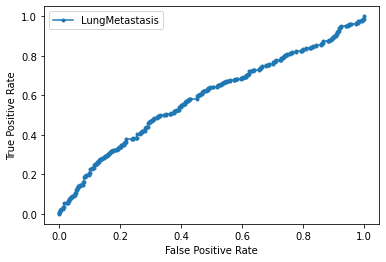

In [72]:
pred = base_model_eval_pred(model_base,device,test_loader)
target_bool = [y for _,y in test_loader]
print(pred)
auc = roc_auc_score(target_bool, pred)
print('AUC=%.3f' % (auc))

fpr, tpr, _ = roc_curve(target_bool, pred)

pyplot.plot(fpr, tpr, marker='.', label='LungMetastasis')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

### Lime

In [73]:
def batch_predict(images):
    model_base.eval()
    batch=[]
    for i in range(images.shape[0]):
        batch.append(transforms.ToTensor()(images[i,:,:,0]))
    batch=torch.stack(batch)
    model_base.to(device)
    batch = batch.to(device)
    logits = model_base(batch)
    probs = torch.sigmoid(logits)
    return logits.detach().cpu().numpy()

In [97]:
labels

array([1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0.])

In [114]:
max(np.max(ct) for ct in cts)

65535.0

In [106]:
type(cts)

list

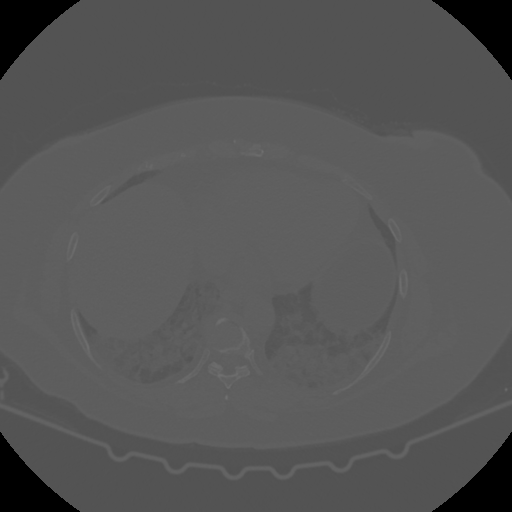

In [113]:
Image.fromarray(cts[3][:,:,310]*255/22000).show()

  0%|          | 0/1000 [00:00<?, ?it/s]

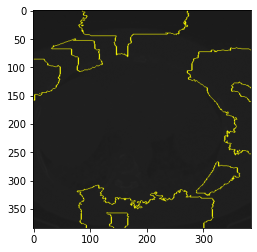

In [116]:
img=transforms.CenterCrop(cropped_size)(Image.fromarray(cts[3][:,:,310]*255/max_HU).convert("L"))
shape=list(img.size)+[3]
shape=tuple(shape)
imgg=np.zeros(shape)
for i in range(3):
    imgg[...,i]=img
explanation = explainer.explain_instance(np.array(img), 
                                     batch_predict, # classification function
                                     top_labels=1, 
                                     hide_color=0, 
                                     num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

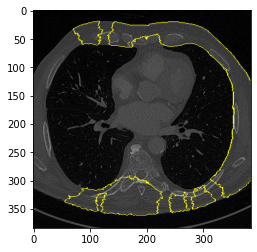

In [94]:
explainer = lime_image.LimeImageExplainer()
for ct in cts:
    img=transforms.CenterCrop(cropped_size)(Image.fromarray(ct[:,:,310]*255/max_HU).convert("L"))
    shape=list(img.size)+[3]
    shape=tuple(shape)
    imgg=np.zeros(shape)
    for i in range(3):
        imgg[...,i]=img
    explanation = explainer.explain_instance(np.array(img), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=False)
    img_boundry1 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry1)

In [92]:
labels

array([1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0.])

In [74]:
img=transforms.CenterCrop(cropped_size)(Image.fromarray(cts[1][:,:,310]*255/max_HU).convert("L"))
shape=list(img.size)+[3]
shape=tuple(shape)
imgg=np.zeros(shape)
for i in range(3):
    imgg[...,i]=img

In [75]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(img), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
np.array(sample_img).shape

In [ ]:
np.unique(mask)

In [ ]:
Image.fromarray(temp)

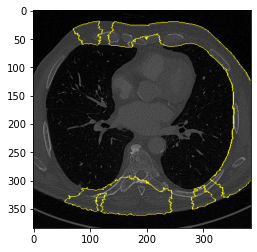

In [85]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

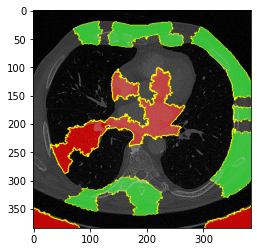

In [84]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

# Evaluating on CTs

Itt összesítem CT-kre a validáción:

In [86]:
def base_model_eval_whole(model, device, test_loader):
    preds = []
    correct = []
    with torch.no_grad():
        for images, label in test_loader:
            slice_preds=[]
            for image in images:
                image = image.to(device)
                image = image.view(-1, 1, cropped_size, cropped_size)
                outputs = model(image).cpu().numpy()
                slice_preds.append(outputs[0][0])
            correct.append(label)
            preds.append(np.asarray(slice_preds))
    return preds, np.asarray(correct)

In [87]:
preds, target_bool = base_model_eval_whole(model_base, device, whole_test_loader)

max_preds= [np.max(slices) for slices in preds]
mean_preds= [np.mean(slices) for slices in preds]

AUC of Max method=0.592
[1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.] [0.2999845, 0.1282696, 0.0017548974, 0.2514999, 0.1408452, 0.29402393, 0.114988774, 0.32375365, 0.30517015, 0.2058069, 0.11467054, 0.33632195, 0.1623032, 0.1793941, 0.12582019, 0.060083248, 0.16509096, 0.06059911, 0.20951928, 0.06264376, 0.060529884, 0.06001683, 0.061035678]


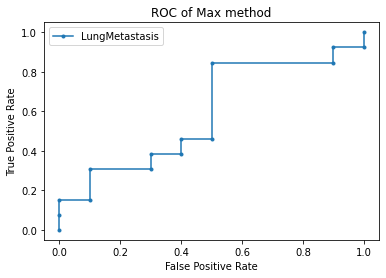

In [88]:
auc_max = roc_auc_score(target_bool, max_preds)
print('AUC of Max method=%.3f' % (auc_max))

print(target_bool, max_preds)
fpr, tpr, _ = roc_curve(target_bool, max_preds)

pyplot.plot(fpr, tpr, marker='.', label='LungMetastasis')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC of Max method')
pyplot.legend()
pyplot.show()

AUC of Mean method=0.608
[1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.] [0.23987441, 0.11292226, -0.016141023, 0.18420762, 0.111182585, 0.25012758, 0.0912801, 0.26943254, 0.27432358, 0.17920558, 0.09030034, 0.30727628, 0.12342615, 0.13693793, 0.091849856, 0.057027254, 0.14581625, 0.05625041, 0.1686358, 0.0576292, 0.05728429, 0.056910936, 0.057108816]


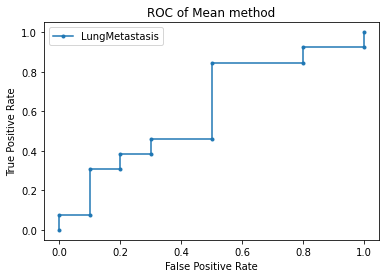

In [89]:
auc_mean = roc_auc_score(target_bool, mean_preds)
print('AUC of Mean method=%.3f' % (auc_mean))

print(target_bool, mean_preds)
fpr, tpr, _ = roc_curve(target_bool, mean_preds)

pyplot.plot(fpr, tpr, marker='.', label='LungMetastasis')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC of Mean method')
pyplot.legend()
pyplot.show()